In [2]:

import os
import glob
import json
import h5py
import optparse
import sys
import traceback

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy as sp
import statsmodels as sm
import cPickle as pkl

import numpy as np
from scipy.optimize import leastsq
import pylab as plt


from pipeline.python.utils import natural_keys, label_figure
from pipeline.python.retinotopy import target_visual_field as vf

In [3]:
%matplotlib notebook

In [4]:

def extract_options(options):
    
    parser = optparse.OptionParser()

    parser.add_option('-D', '--root', action='store', dest='rootdir', default='/n/coxfs01/2p-data', help='data root dir (root project dir containing all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid', default='', help='Animal ID')

    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session', default='', \
                      help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition', default='FOV1', \
                      help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-R', '--run', action='store', dest='run', default='retino_run1', \
                      help="name of run dir containing tiffs to be processed (ex: gratings_phasemod_run1)")
    parser.add_option('-t', '--retinoid', action='store', dest='retinoid', default='analysis001', \
                      help="name of retino ID (roi analysis) [default: analysis001]")
    
    parser.add_option('--angular', action='store_false', dest='use_linear', default=True, \
                      help="Plot az/el coordinates in angular spce [default: plots linear coords]")
#     parser.add_option('-e', '--thr-el', action='store', dest='fit_thresh_el', default=0.2, \
#                       help="fit threshold for elevation [default: 0.2]")
#     parser.add_option('-a', '--thr-az', action='store', dest='fit_thresh_az', default=0.2, \
#                       help="fit threshold for azimuth [default: 0.2]")
    
    (options, args) = parser.parse_args(options)

    return options


## Select data set

In [5]:

#%%

options = ['-i', 'JC047', '-S', '20190215', '-A', 'FOV1']
#options = ['-i', 'JC059', '-S', '20190228', '-A', 'FOV1']


In [6]:
opts = extract_options(options)

rootdir = opts.rootdir
animalid = opts.animalid
session = opts.session
fov = opts.acquisition
run = opts.run
retinoid = opts.retinoid
use_linear = opts.use_linear
#fit_thresh_az = float(opts.fit_thresh_az)
#fit_thresh_el = float(opts.fit_thresh_el) #0.2


# Select retino analysis

In [69]:

#%%
use_pixels = True
run_dir = glob.glob(os.path.join(rootdir, animalid, session, '%s*' % fov, run))[0]
fov = os.path.split(os.path.split(run_dir)[0])[-1]
print("FOV: %s, run: %s" % (fov, run))
retinoids_fpath = glob.glob(os.path.join(run_dir, 'retino_analysis', 'analysisids_*.json'))[0]
with open(retinoids_fpath, 'r') as f:
    rids = json.load(f)
if use_pixels:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] == 'pixels']
else:
    roi_analyses = [r for r, rinfo in rids.items() if rinfo['PARAMS']['roi_type'] != 'pixels']
if retinoid not in roi_analyses:
    retinoid = sorted(roi_analyses, key=natural_keys)[-1] # use most recent roi analysis
    print("Fixed retino id to most recent: %s" % retinoid)

data_identifier = '|'.join([animalid, session, fov, run, retinoid])

print("*** Dataset: %s ***" % data_identifier)

#%%
# Get processed retino data:
processed_dir = glob.glob(os.path.join(run_dir, 'retino_analysis', '%s*' % retinoid))[0]
processed_fpaths = glob.glob(os.path.join(processed_dir, 'files', '*.h5'))
print("Found %i processed retino runs." % len(processed_fpaths))

# Get condition info for trials:
conditions_fpath = glob.glob(os.path.join(run_dir, 'paradigm', 'files', '*.json'))[0]


FOV: FOV1_zoom4p0x, run: retino_run1
Fixed retino id to most recent: analysis001
*** Dataset: JC047|20190215|FOV1_zoom4p0x|retino_run1|analysis001 ***
Found 12 processed retino runs.


# Format data

In [70]:

# Comine all trial data into data frames:
fit, magratio, phase, trials_by_cond = vf.trials_to_dataframes(processed_fpaths, conditions_fpath)
#print fit.head()
print trials_by_cond


# Correct phase to wrap around:
corrected_phase = vf.correct_phase_wrap(phase)



1: retino_data_FOV1_retino_Slice01_Channel01_File001.h5
2: retino_data_FOV1_retino_Slice01_Channel01_File002.h5
3: retino_data_FOV1_retino_Slice01_Channel01_File003.h5
4: retino_data_FOV1_retino_Slice01_Channel01_File004.h5
5: retino_data_FOV1_retino_Slice01_Channel01_File005.h5
6: retino_data_FOV1_retino_Slice01_Channel01_File006.h5
7: retino_data_FOV1_retino_Slice01_Channel01_File007.h5
8: retino_data_FOV1_retino_Slice01_Channel01_File008.h5
9: retino_data_FOV1_retino_Slice01_Channel01_File009.h5
10: retino_data_FOV1_retino_Slice01_Channel01_File010.h5
11: retino_data_FOV1_retino_Slice01_Channel01_File011.h5
12: retino_data_FOV1_retino_Slice01_Channel01_File012.h5
{u'top': [11, 5, 6], u'right': [1, 4, 8], u'left': [10, 2, 7], u'bottom': [12, 3, 9]}


## Get screen info

In [71]:
# Get screen info:
screen = vf.get_screen_info(animalid, session, rootdir=rootdir)


# Convert phase to linear coords:
screen_left = -1*screen['azimuth']/2.
screen_right = screen['azimuth']/2. #screen['azimuth']/2.
screen_lower = -1*screen['elevation']/2.
screen_upper = screen['elevation']/2. #screen['elevation']/2.


Found epi sessions: ['20190215']
Most recent: 20190215
('-- getting screen info from:', ['/n/coxfs01/2p-data/JC047/epi_maps/20190215/screen_boundaries_20190215_epi_run8_fwhm_7_thresh_0.02.json', '/n/coxfs01/2p-data/JC047/epi_maps/20190215/screen_boundaries_20190215_epi_run3_fwhm_7_thresh_0.1.json'])


## Set output dir

In [72]:
roi_fit_dir = os.path.join(processed_dir, 'fits')
if not os.path.exists(roi_fit_dir):
    os.makedirs(roi_fit_dir)
print("Saving fit results to: %s" % roi_fit_dir)

Saving fit results to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis001_9b4dc6/fits


#### Get list of "best fit" or highest-mag ratio ROIs:

In [19]:
threshold = 0.25


In [23]:
mean_fits = fit.mean(axis=1)
best_fits = mean_fits[mean_fits >= threshold].index.tolist()
print("ROIs with best fit (n=%i, thr=%.2f):" % (len(best_fits), threshold), best_fits)

# print corrected_phase[trials_by_cond['right']].head()
# print corrected_phase[trials_by_cond['right']].iloc[26]
# print "Circular mean:", sp.stats.circmean(corrected_phase[trials_by_cond['right']].iloc[26])

('ROIs with best fit (n=24, thr=0.25):', [3, 13, 17, 19, 26, 27, 28, 31, 36, 37, 42, 46, 53, 55, 62, 63, 65, 77, 80, 83, 91, 97, 102, 107])


## Load traces averaged by condition:

In [25]:
# This file gets created with visualization/get_session_summary() when estimate_RF_size.py is used

avg_traces_fpath = glob.glob(os.path.join(processed_dir, 'traces', '*.pkl'))[0]
print("Loading pre-averaged traces from: %s" % avg_traces_fpath)

with open(avg_traces_fpath, 'rb') as f:
    traces = pkl.load(f)
print("averaged_traces.pkl contains:", traces.keys())

# trials_by_cond = traces['conditions']
# print("Conditions (by rep):", trials_by_cond)

print "Cond dict:", traces['traces']['right']

Loading pre-averaged traces from: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis002_d96d67/traces/averaged_roi_traces.pkl
('averaged_traces.pkl contains:', ['source_tifs', 'traces', 'RETINOID', 'masks', 'mwinfo', 'conditions'])
Cond dict: {'info': {'stimulus': u'right', 'stimfreq': 0.13, 'frame_rate': 44.6329, 'n_reps': 3}, 'traces': array([[  3.79618043e+00,   3.65672880e+00,   3.75006778e+00, ...,
          2.42589203e+00,   5.22900404e-01,  -1.12550637e+00],
       [ -5.46177363e+00,  -4.25502803e+00,  -5.06569435e+00, ...,
         -3.04327511e-01,  -3.43201620e+00,  -3.24832549e+00],
       [  1.71320712e+00,   2.19038241e+00,   2.09775858e-03, ...,
         -3.51555743e+00,  -2.72986144e+00,  -4.17969142e-01],
       ..., 
       [  9.46756677e+00,   4.26263107e+00,   2.26369001e+00, ...,
         -1.74497523e+00,  -1.34530110e+00,  -1.40808100e+00],
       [ -8.16790348e+00,  -1.22812778e+01,  -1.83349096e+01, ...,
          1.72754919e+01, 

#### Get stimulus info

In [26]:
# Get cycle starts:
cond = 'right'
stimfreq = traces['traces'][cond]['info']['stimfreq']
stimperiod = 1./stimfreq # sec per cycle
fr = traces['traces'][cond]['info']['frame_rate']
nframes = traces['traces'][cond]['traces'].shape[-1]

ncycles = int(round((nframes/fr) / stimperiod))
print stimperiod

nframes_per_cycle = int(np.floor(stimperiod * fr))
cycle_starts = np.round(np.arange(0, stimperiod*fr*ncycles, nframes_per_cycle)).astype('int')
print("Cycle starts (%i cycles):" % (ncycles), cycle_starts)

7.69230769231
('Cycle starts (12 cycles):', array([   0,  343,  686, 1029, 1372, 1715, 2058, 2401, 2744, 3087, 3430,
       3773, 4116]))


#### Visualize top / "best-fit" cells' time courses:

<IPython.core.display.Javascript object>


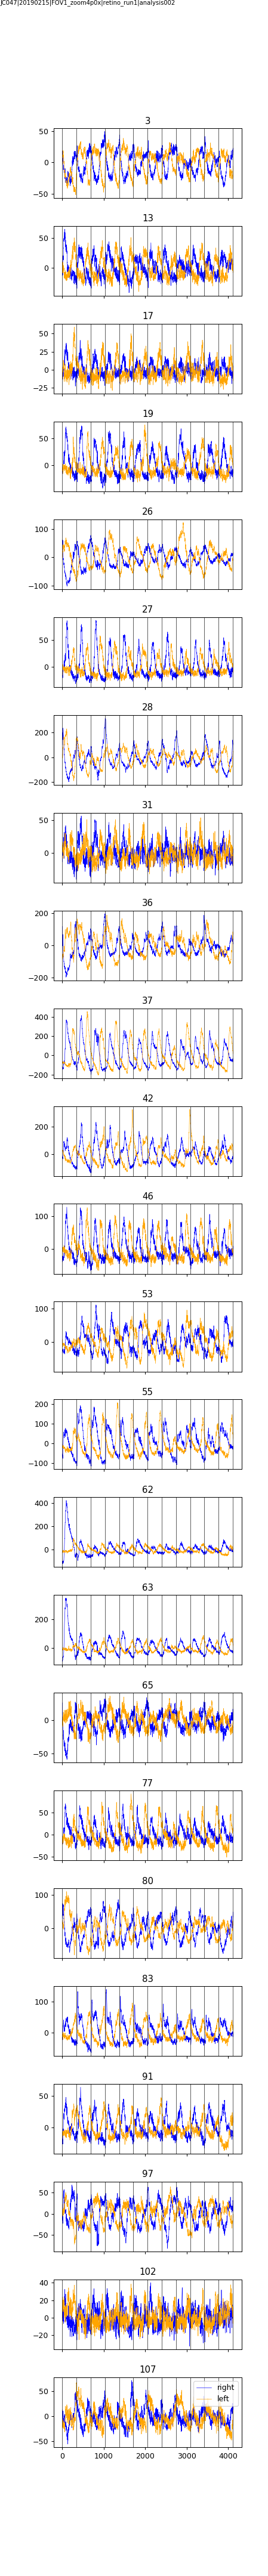

In [27]:
fig, ax = pl.subplots(len(best_fits), 1, figsize=(5, len(best_fits)*2), sharex=True) #pl.figure()

for ri,rid in enumerate(best_fits):
    ax[ri].plot(traces['traces']['right']['traces'][rid, :], 'b', lw=0.5, label='right')
    ax[ri].plot(traces['traces']['left']['traces'][rid, :], 'orange', lw=0.5, label='left')
    ax[ri].set_title('%i' % rid)
    for cyc in cycle_starts:
        ax[ri].axvline(x=cyc, color='k', lw=0.5)
fig.subplots_adjust(hspace=0.4, top=0.95, bottom=0.05, left=0.2)
ax[-1].legend()

label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'traces_best_rois_azimuth.png'))


# Redo regression on average roi trace 
Get average across reps of condition)

In [28]:

def lst_sq_fit(data, t, init_phase=0, init_freq=1, init_amp=1, use_cos=True):
    init_mean = np.mean(data)
    init_std = 3*np.std(data)/(2**0.5)/(2**0.5)
    #guess_phase = sp.stats.circmean(corrected_phase[trials_by_cond[cond]].iloc[rid]) #0
    #guess_freq = 1 #1 #1
    #guess_amp = np.max(data) #1

    # we'll use this to plot our first estimate. This might already be good enough for you
    if use_cos:
        data_first_guess = init_std * np.cos(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.cos(x[1]*t+x[2]) + x[3] - data
    else:
        data_first_guess = init_std * np.sin(t+init_phase) + init_mean
        optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - data


    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    fit_amp, fit_freq, fit_phase, fit_mean = leastsq(optimize_func, [init_amp, init_freq, init_phase, init_mean])[0]

    # recreate the fitted curve using the optimized parameters
    if use_cos:
        data_fit = fit_amp*np.cos(fit_freq * t + fit_phase) + fit_mean
    else:
        data_fit = fit_amp*np.sin(fit_freq * t + fit_phase) + fit_mean

    params =  {'init_phase': init_phase,
              'init_amp': init_amp,
              'init_freq': init_freq,
              'fit_phase': fit_phase,
              'fit_amp': fit_amp,
              'fit_freq': fit_freq,
              'fit_mean': fit_mean,
              't': t}
    
    return data_fit, params #est_amp, est_freq, est_phase, est_mean


In [29]:

def fit_roi_trace(roi_data, roi_phases, t, use_cos=True): #, guess_phase=0, guess_freq=1, guess_amp=1):
    conditions = roi_data.columns.tolist()
    print conditions
    fit_results = {}
    for cond in conditions:
        print("fitting... %s" % cond)
        data = roi_data[cond].values #3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise
        init_phase = roi_phases[cond].values
        init_amp = np.max(data)
        init_freq = 1
        data_fit, params = lst_sq_fit(data, t, use_cos=use_cos, init_phase=init_phase, init_freq=init_freq, init_amp=init_amp)
        
        fit_results[cond] = {'fit': data_fit, 'params': params}
        
    return fit_results

In [30]:

def plot_fit_by_condition(fit_results, data=None, t=None, color='k', label='label', ax=None, annot_loc=0):
    if ax is None:
        fig, ax = pl.subplots()

    #fig, ax = pl.subplots(1, 2, figsize=(15,5)) # = pl.figure()
    if t is not None and data is not None:
        ax.plot(t, data, color=color, lw=0.2, alpha=0.5)
        
    #data_fit = fit_results['fit_amp'] * np.sin(fit_results['fit_freq'] * fit_t + fit_results['fit_phase']) + fit_results['fit_mean']
    data_fit = fit_results['fit']
    ax.plot(fit_results['params']['t'], data_fit, color=color, label=label)
    
    cond_str = "[%s] True: %.2f, Est: %.2f" % (label, fit_results['params']['init_phase'], fit_results['params']['fit_phase'])
    ax.text(ax.get_xlim()[0], annot_loc, cond_str) #ax.get_ylim()[-1]-100, cond_str)
    ax.legend(loc='lower right')


In [31]:

frame_period = 1./fr
t_frames = np.arange(frame_period, frame_period * (nframes+1), frame_period)
print t_frames[0:5]

# rinfo_fpath = glob.glob(os.path.join(run_dir, '*.json'))[0]
# with open(rinfo_fpath, 'r') as f:
#     rinfo = json.load(f)
# print rinfo['frame_tstamps_sec'][0:5]
# t_frames = np.array(rinfo['frame_tstamps_sec'])

t = t_frames * (2*np.pi) * stimfreq


[ 0.022405    0.04480999  0.06721499  0.08961999  0.11202499]


In [35]:
use_cos = True
use_corrected = False
if use_corrected:
    highval = 2*np.pi # np.pi
    lowval = 0 #-np.pi
    phase_array = corrected_phase.copy()
else:
    highval = np.pi
    lowval = -np.pi
    phase_array = phase.copy()

#### Look at 1 roi first:

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


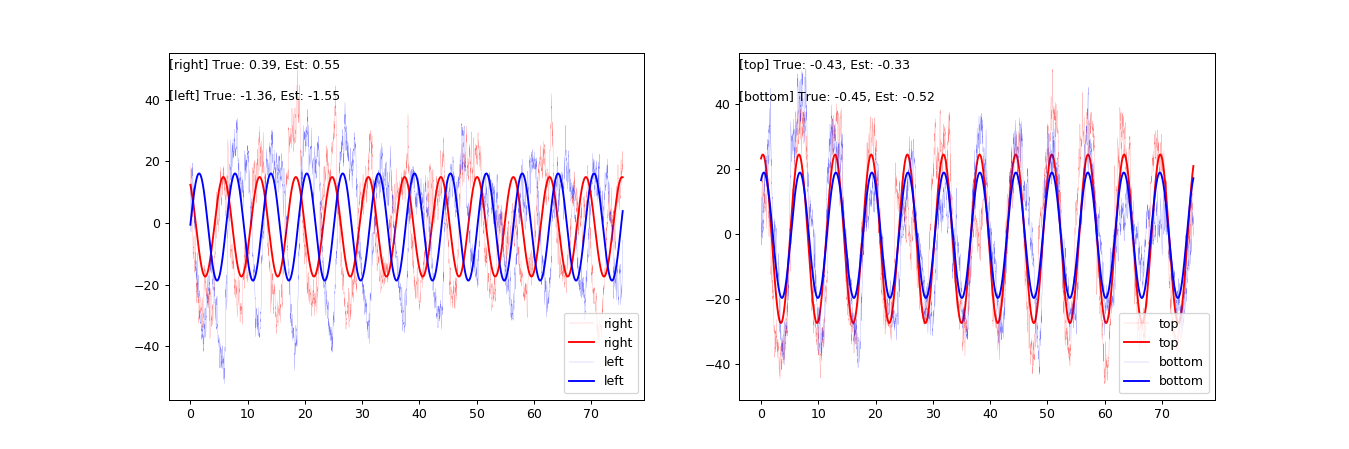

In [50]:
rid = 3
roi_data = pd.concat((pd.Series(data=traces['traces'][cond]['traces'][rid, :], name=cond) \
                      for cond in conditions), axis=1)
roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trials_by_cond[cond]].iloc[rid], \
                                                            high=highval, low=lowval), name=cond))\
                          for cond in conditions).T

fit_results = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)

fig, ax = pl.subplots(1, 2, figsize=(15,5)) # = pl.figure()

    
# Azimuth conditions:
maxloc = max([roi_data['right'].max(), roi_data['left'].max()])
plot_fit_by_condition(roi_fit['right'], data=roi_data['right'], t=t, 
                      color='r', label='right', ax=ax[0], annot_loc=maxloc)
plot_fit_by_condition(roi_fit['left'], data=roi_data['left'], t=t, 
                      color='b', label='left', ax=ax[0],  annot_loc=maxloc-10) #maxloc-300)

# Elevation conditions:
maxloc = max([roi_data['top'].max(), roi_data['bottom'].max()])
plot_fit_by_condition(roi_fit['top'], data=roi_data['top'], t=t, 
                      color='r', label='top', ax=ax[1], annot_loc=maxloc)
plot_fit_by_condition(roi_fit['bottom'], data=roi_data['bottom'], t=t, 
                      color='b', label='bottom', ax=ax[1], annot_loc=maxloc-10) #maxloc-300)



#### Fit all rois

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


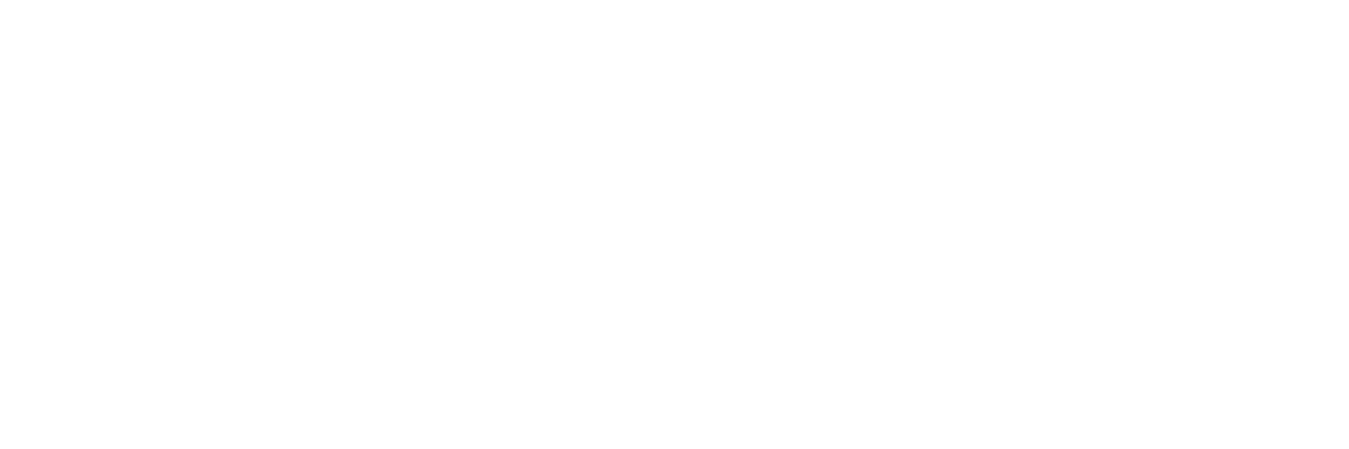

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


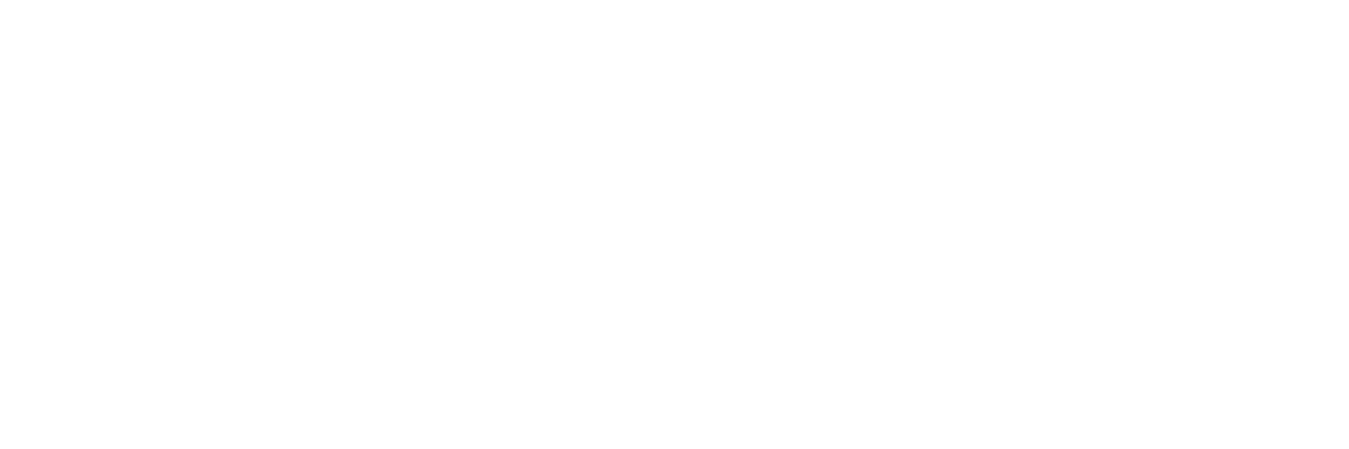

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


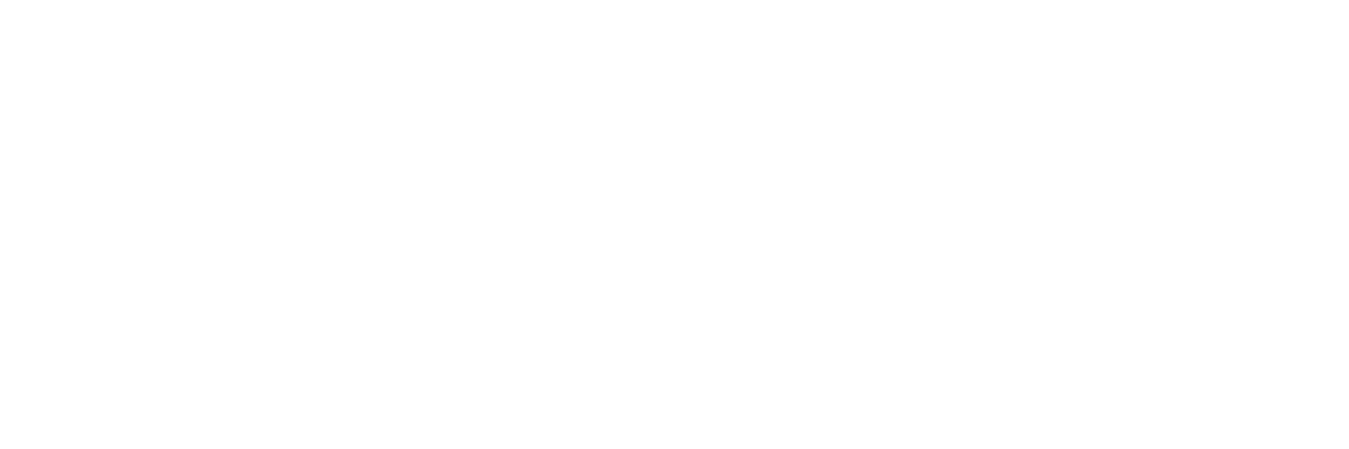

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


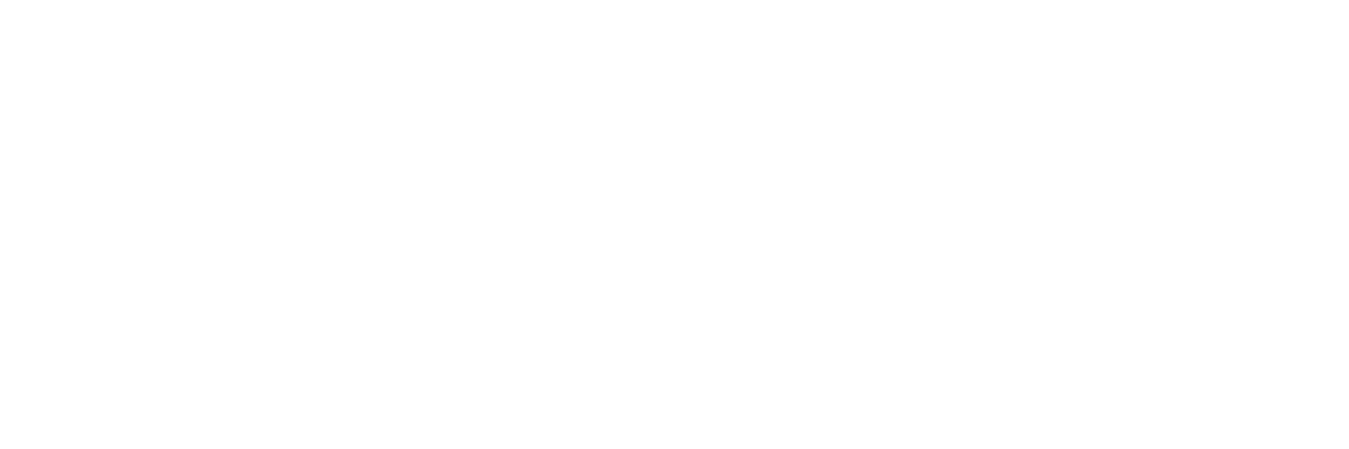

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


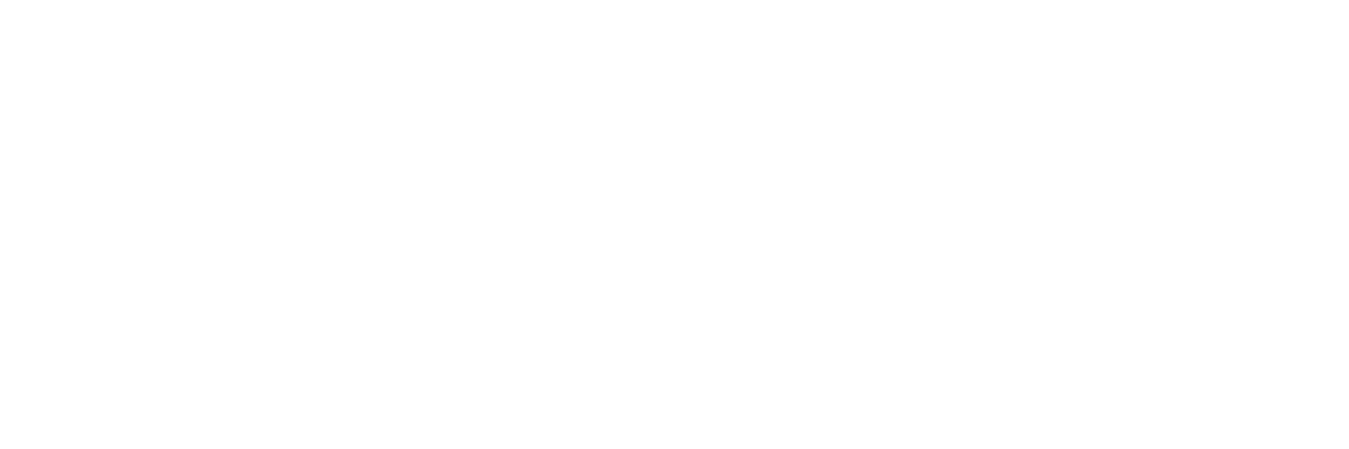

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


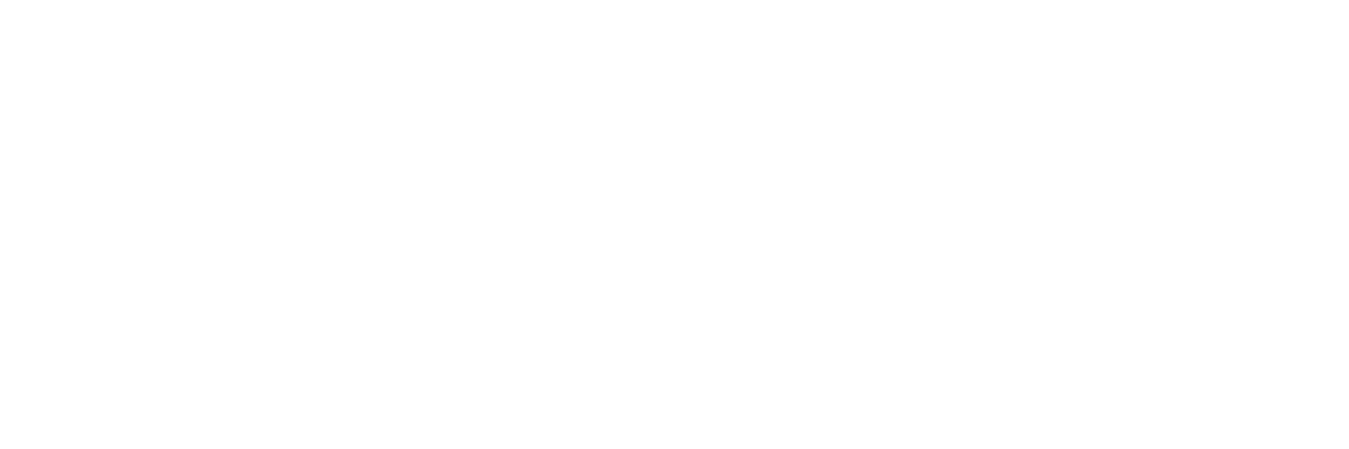

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


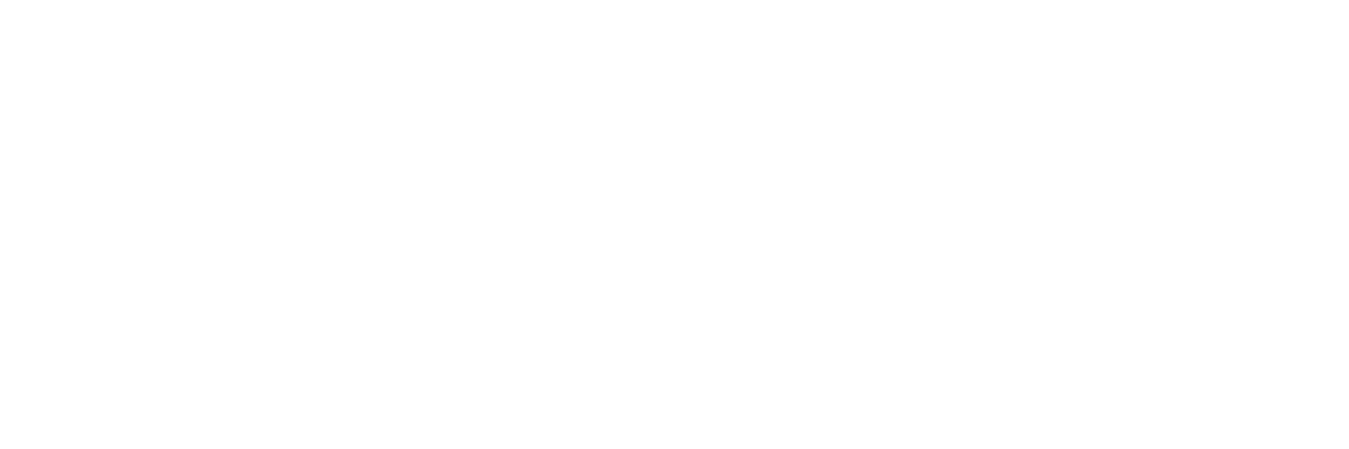

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


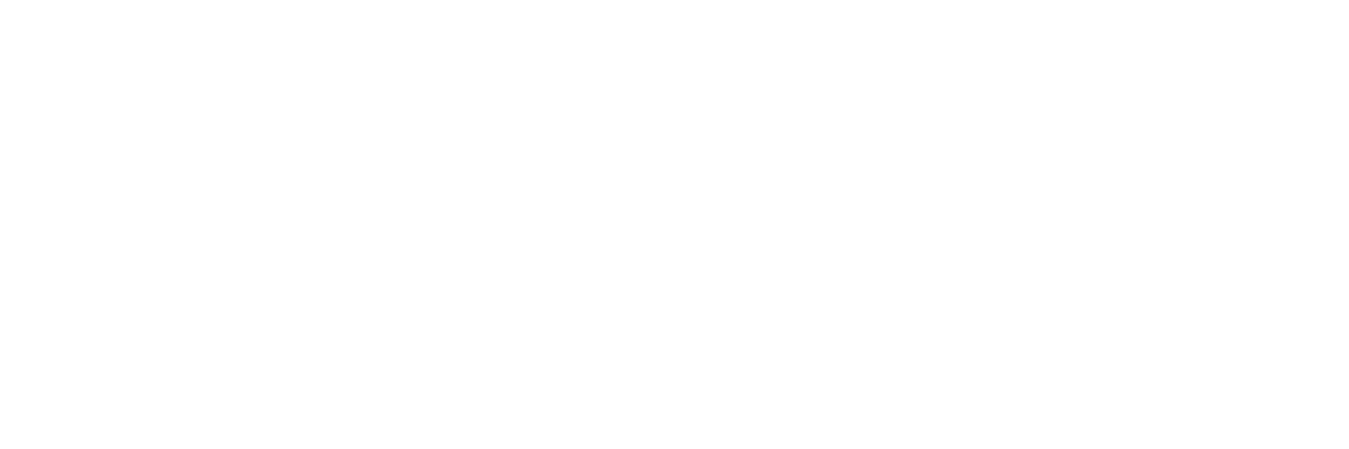

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


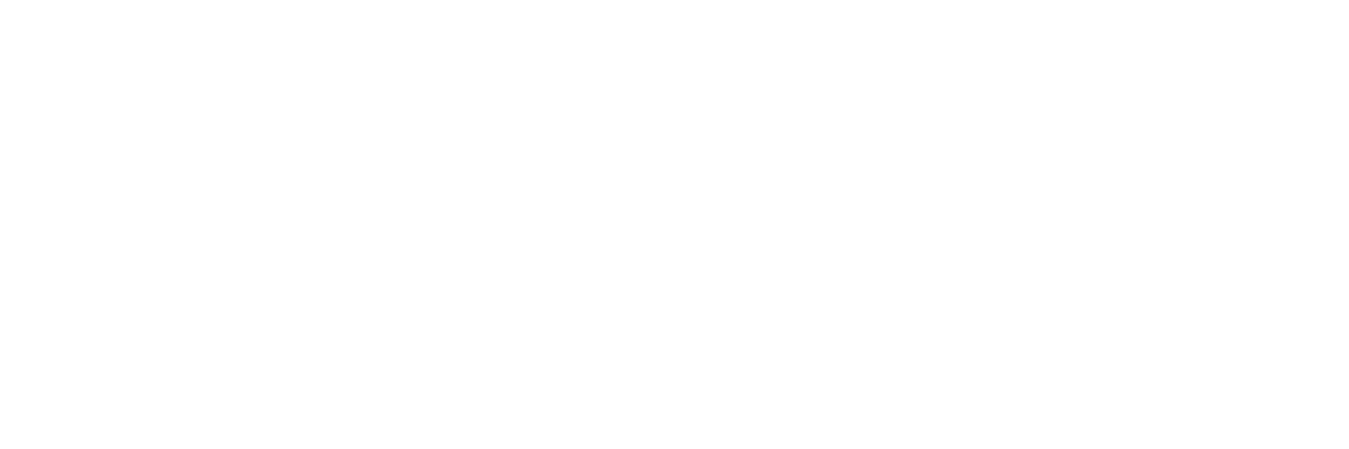

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


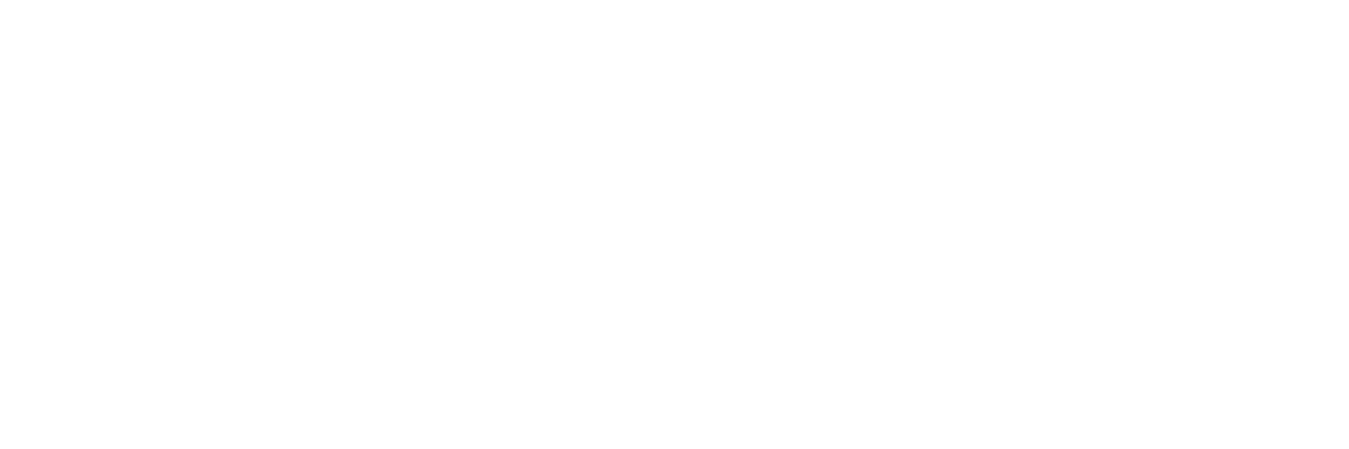

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


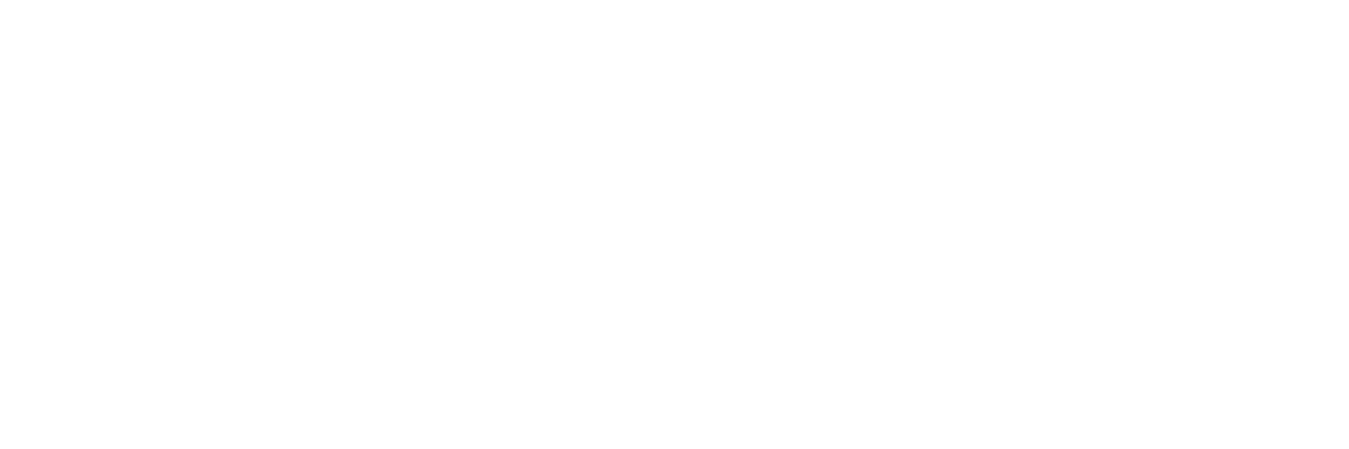

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


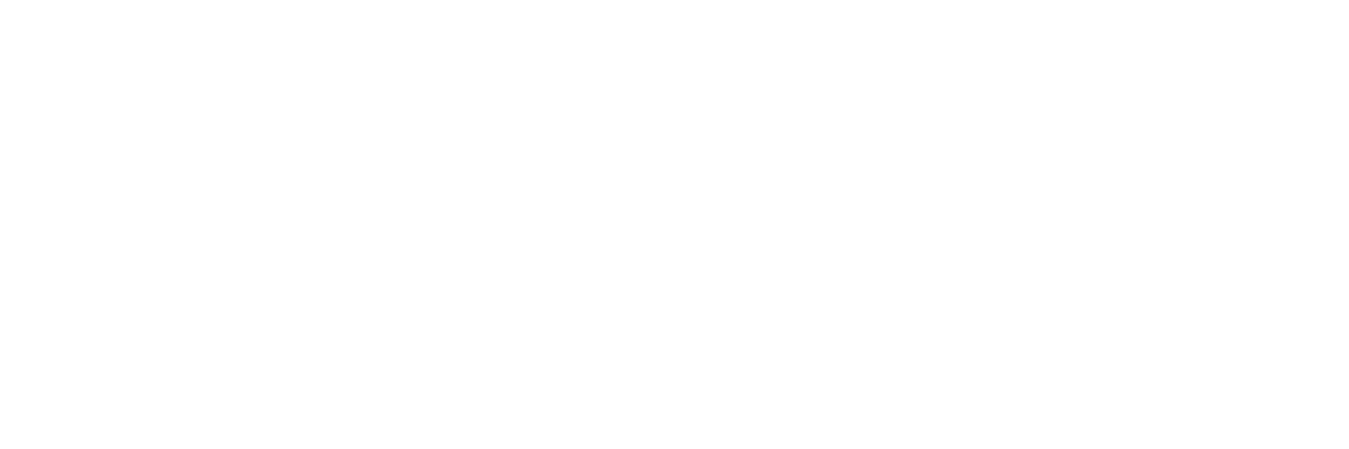

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


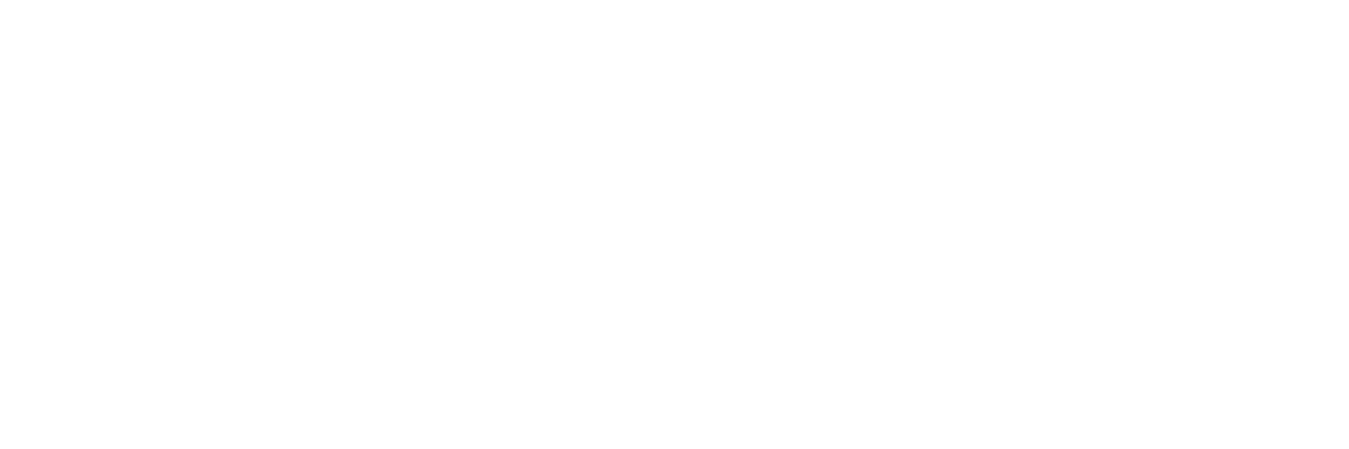

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


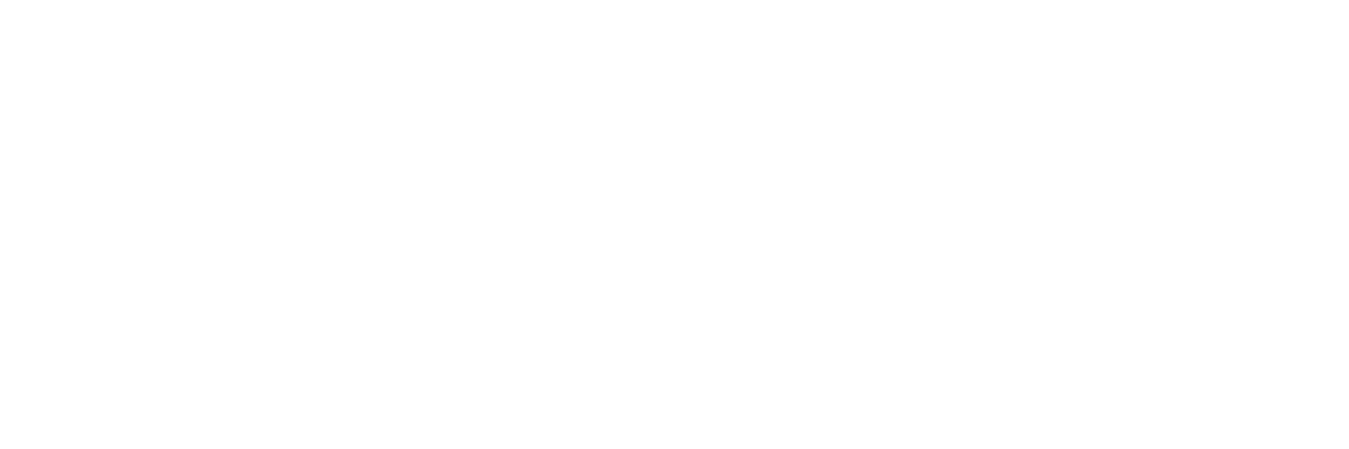

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


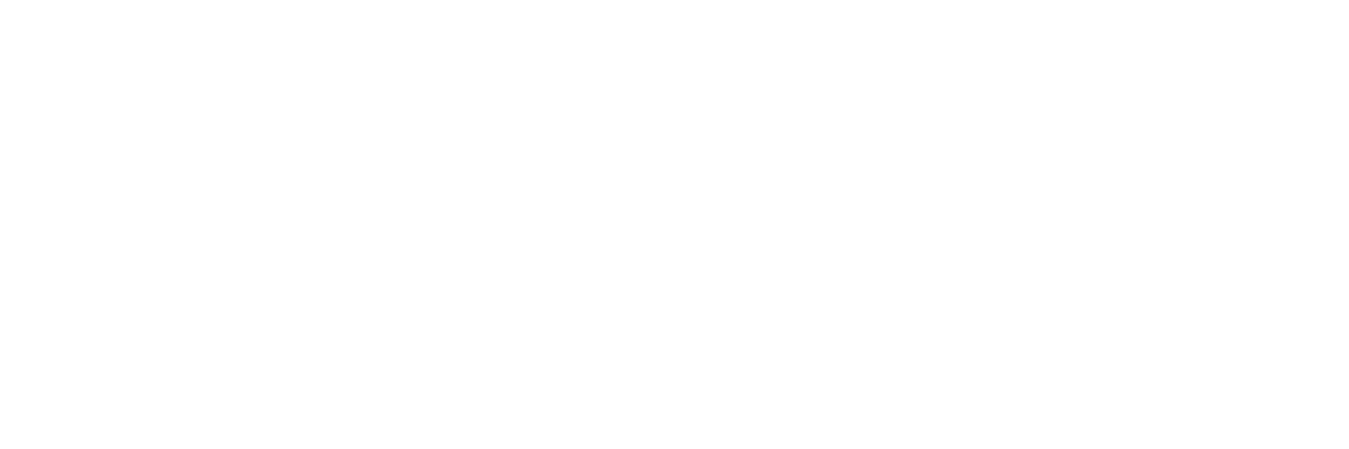

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


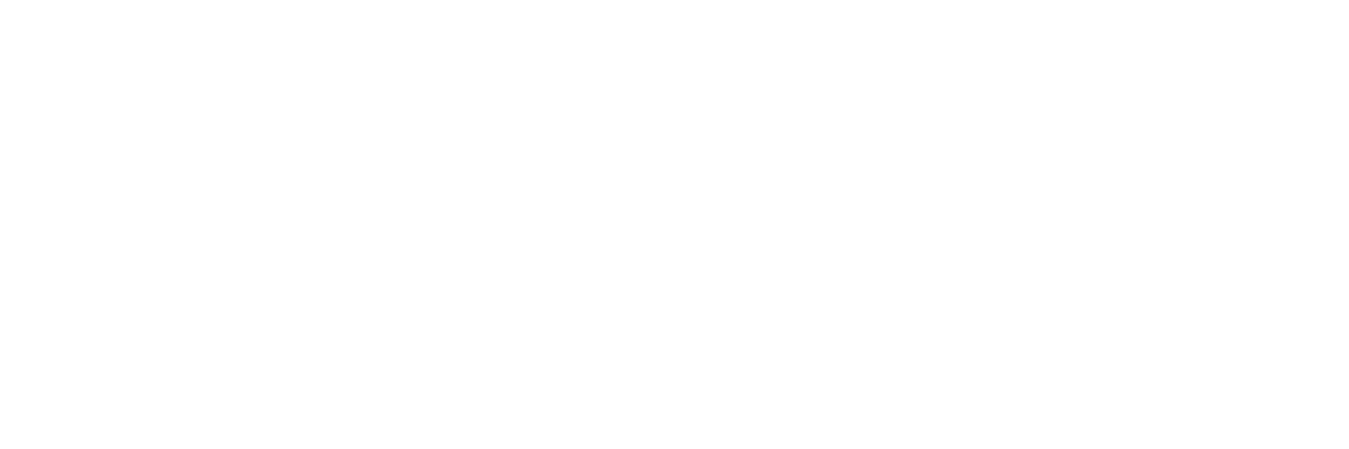

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


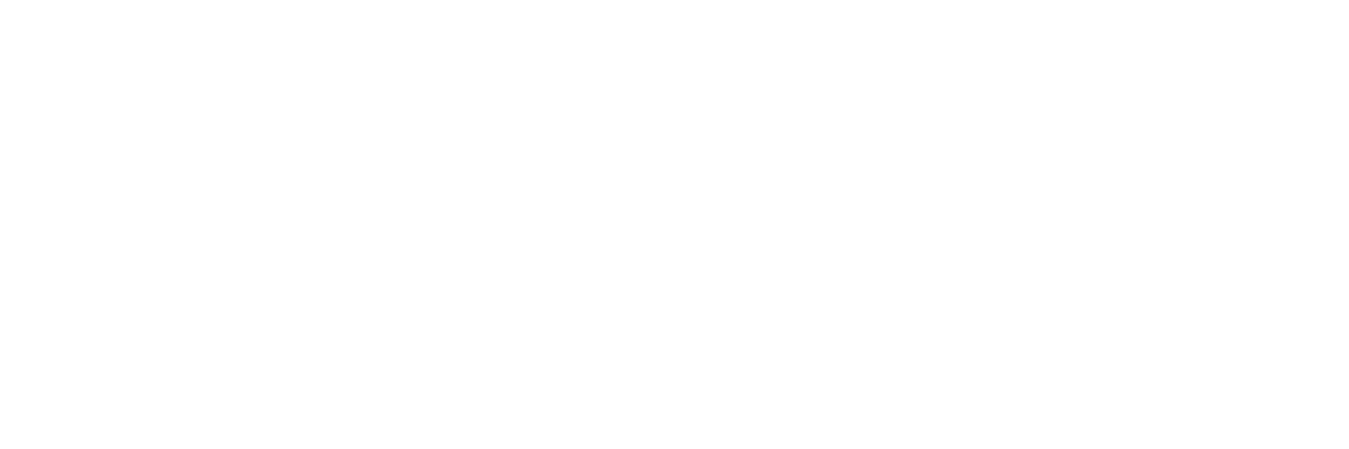

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


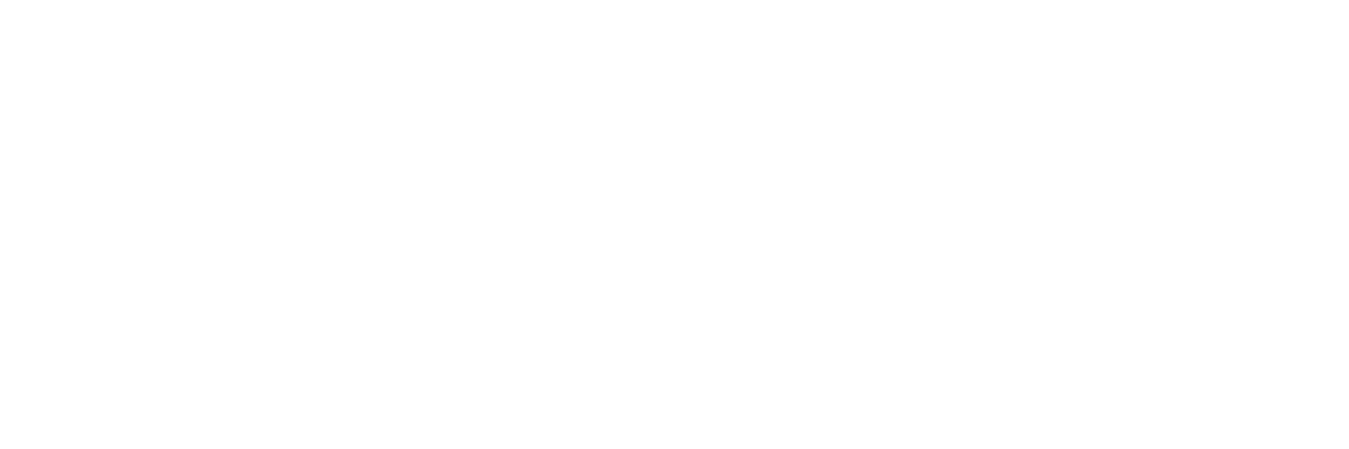

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


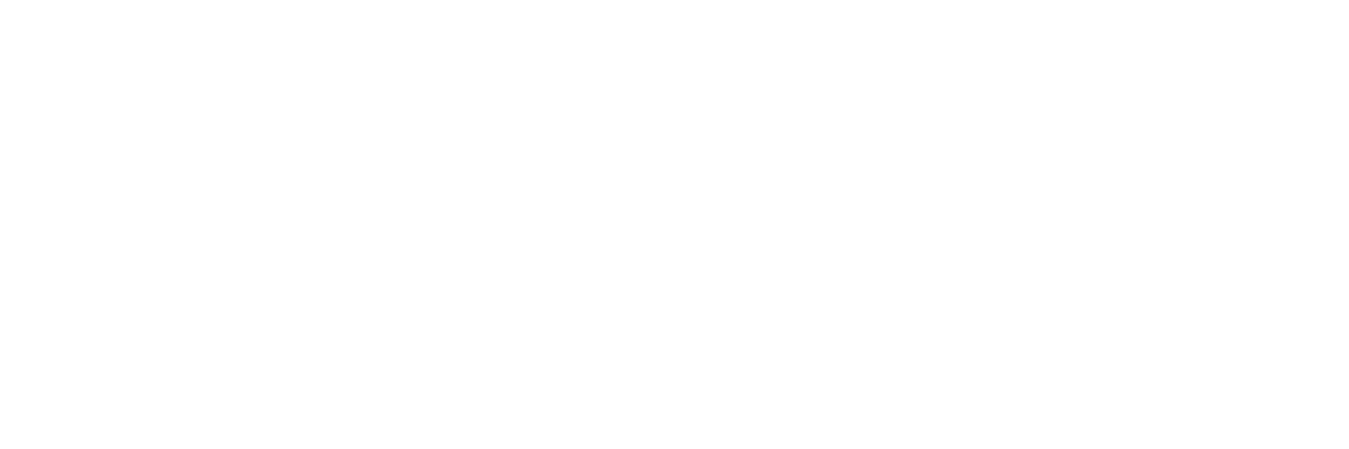

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


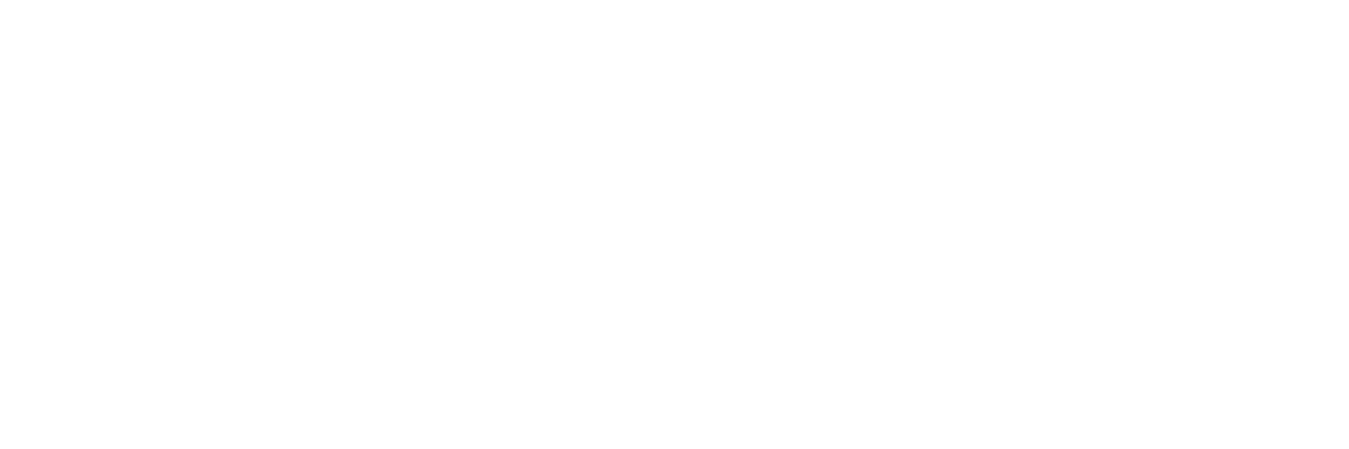

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


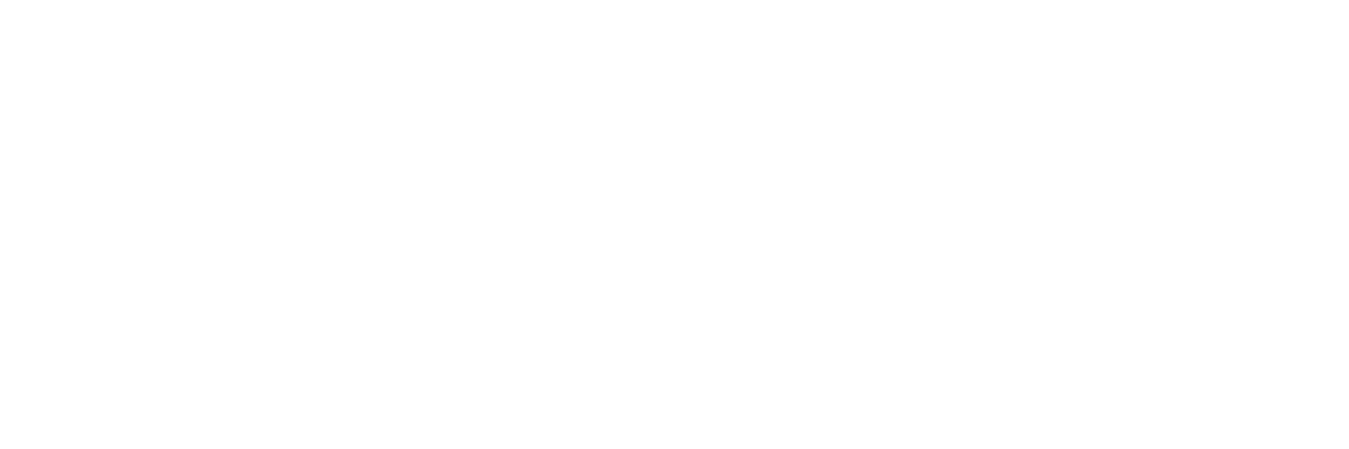

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


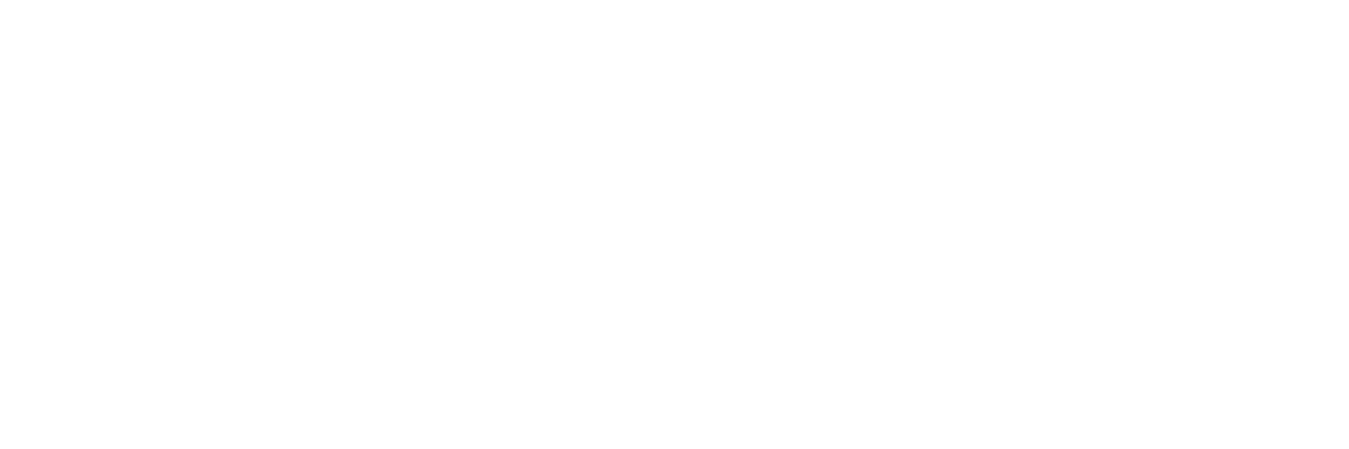

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


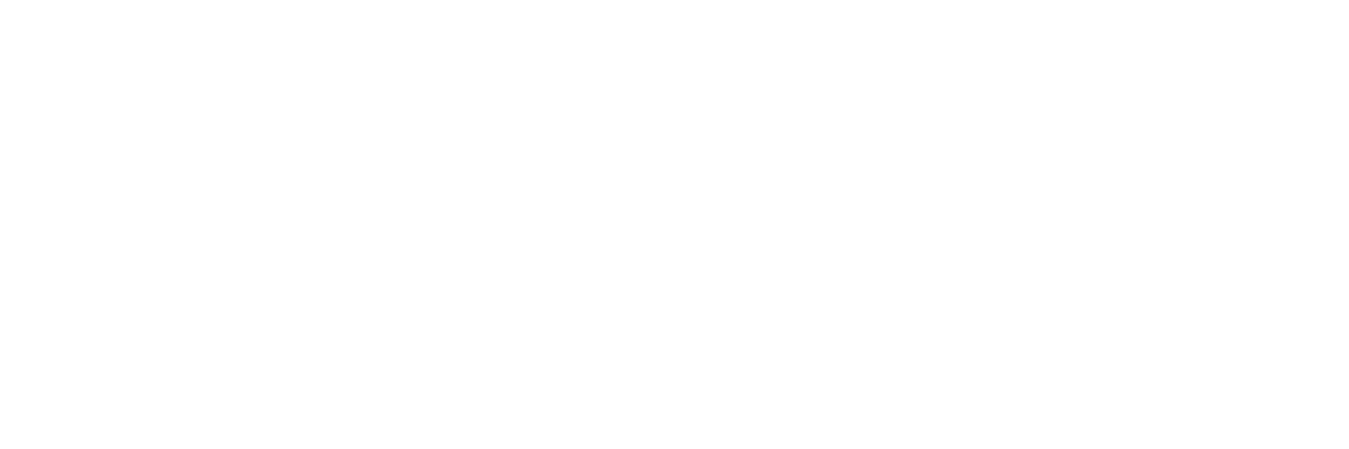

[u'top', u'right', u'bottom', u'left']
fitting... top
fitting... right
fitting... bottom
fitting... left


<IPython.core.display.Javascript object>


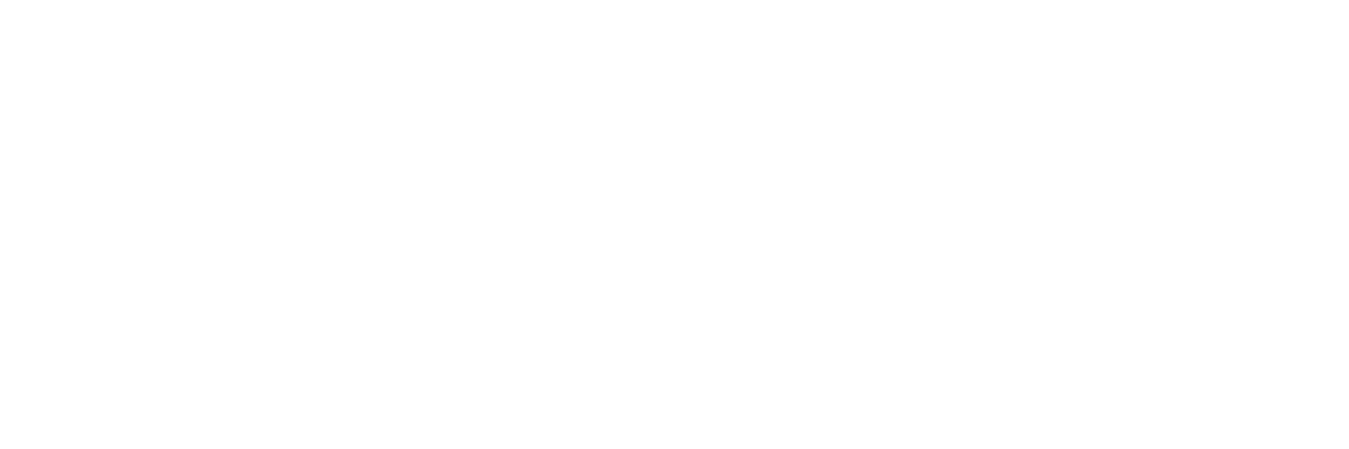

In [56]:
# Make subdir to save each roi's fit:
if not os.path.exists(os.path.join(roi_fit_dir, 'roi_figures')):
    os.makedirs(os.path.join(roi_fit_dir, 'roi_figures'))

fit_results = {}

for rid in best_fits:

    roi_data = pd.concat((pd.Series(data=traces['traces'][cond]['traces'][rid, :], name=cond)\
                          for cond in conditions), axis=1)
    roi_phases = pd.DataFrame((pd.Series(data=sp.stats.circmean(phase_array[trials_by_cond[cond]].iloc[rid], 
                                                                high=highval, low=lowval), 
                                         name=cond)) for cond in conditions).T

    roi_fit = fit_roi_trace(roi_data, roi_phases, t, use_cos=use_cos)
    
    # PLOT ------------------------------------------------------------
    fig, ax = pl.subplots(1, 2, figsize=(15,5)) 
    
    # Azimuth conditions:
    maxloc = max([roi_data['right'].max(), roi_data['left'].max()])
    plot_fit_by_condition(roi_fit['right'], data=roi_data['right'], t=t, 
                          color='r', label='right', ax=ax[0], annot_loc=maxloc)
    plot_fit_by_condition(roi_fit['left'], data=roi_data['left'], t=t, 
                          color='b', label='left', ax=ax[0],  annot_loc=maxloc-10) #maxloc-300)

    # Elevation conditions:
    maxloc = max([roi_data['top'].max(), roi_data['bottom'].max()])
    plot_fit_by_condition(roi_fit['top'], data=roi_data['top'], t=t, 
                          color='r', label='top', ax=ax[1], annot_loc=maxloc)
    plot_fit_by_condition(roi_fit['bottom'], data=roi_data['bottom'], t=t, 
                          color='b', label='bottom', ax=ax[1], annot_loc=maxloc-10) #maxloc-300)

    sns.despine(trim=True, offset=8)
    fig.suptitle('roi %i' % int(rid+1))
    label_figure(fig, data_identifier)

    pl.savefig(os.path.join(roi_fit_dir, 'roi_figures', 'lst_sq_fits_roi%05d.png' % int(rid+1)))
    pl.close()
    
    fit_results[rid] = {'roi_fit': roi_fit,
                         'roi_data': roi_data,
                         'roi_phases': roi_phases,
                         'use_cos': use_cos,
                         'use_corretected': use_corrected}
    
with open(os.path.join(roi_fit_dir, 'fit_results.pkl'), 'wb') as f:
    pkl.dump(fit_results, f, protocol=pkl.HIGHEST_PROTOCOL)
    

#### Compare FIT vs. TRUE (all conditions)

<IPython.core.display.Javascript object>


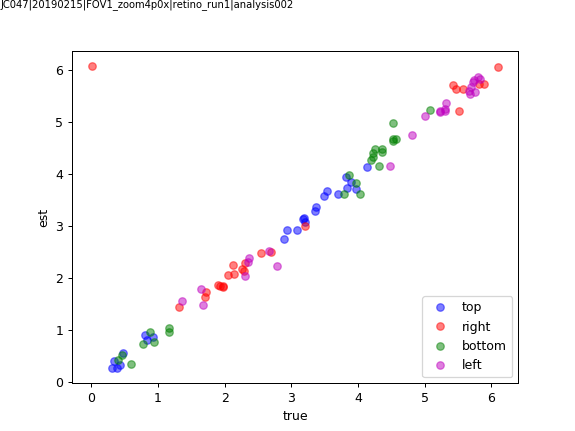

In [59]:
#true_right = [best_fit_results[rid]['fit_results']['right']['params']['init_phase'] for rid in best_fits]
#est_right = [best_fit_results[rid]['fit_results']['right']['params']['fit_phase'] for rid in best_fits]

fig = pl.figure() #figsize=(10,10))
ax = fig.add_subplot(111)

colors = {'right': 'r', 
          'left': 'm',
          'top': 'b',
          'bottom': 'g'}

for ci, cond in enumerate(conditions): #['right']:
    #ax = fig.add_subplot(2, 2, ci+1, projection='polar')
    true = np.array([fit_results[rid]['roi_fit'][cond]['params']['init_phase'] for rid in best_fits])
    est = np.array([fit_results[rid]['roi_fit'][cond]['params']['fit_phase'] for rid in best_fits])
    
    if not use_corrected:
        corrected_true = vf.correct_phase_wrap(true)
        corrected_est = vf.correct_phase_wrap(est)
    
    mag = [magratio[trials_by_cond[cond]].iloc[rid].mean() for rid in best_fits]
    
    ax.plot(corrected_true, corrected_est, 'o',alpha=0.5, label=cond, color=colors[cond])

    pl.legend() #loc='center left', bbox_to_anchor=(1, 0.5))
    
    pl.xlabel('true')
    pl.ylabel('est')
    
label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'true_vs_fit_phases_%.2f.png' % threshold))


#### Compare dir1 vs. dir2 (FIT)

<IPython.core.display.Javascript object>


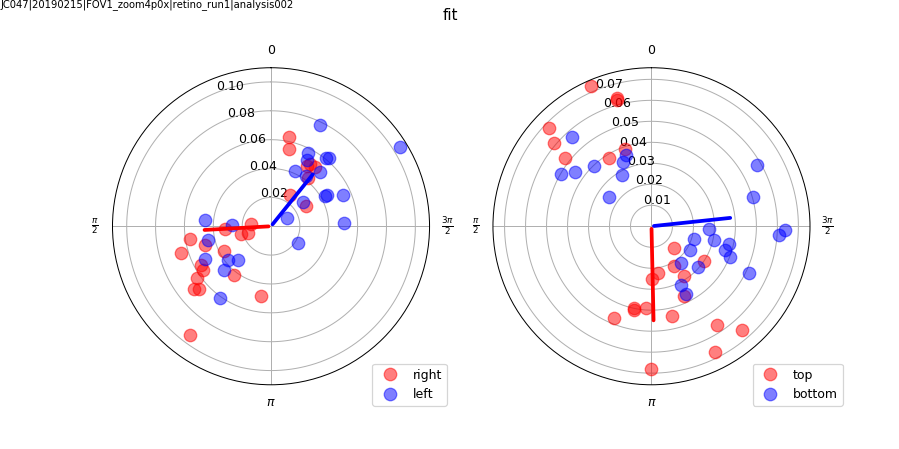

In [60]:
# Plot opposite directions against each other on polar plot:

fig = pl.figure(figsize=(10,5))

color1 = 'r'
color2 = 'b'

xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
xL = xL[::2]

for ci, (c1, c2) in enumerate([['right', 'left'], ['top', 'bottom']]): #['right']:
    ax = fig.add_subplot(1, 2, ci+1, projection='polar')
    cond1 = np.array([fit_results[rid]['roi_fit'][c1]['params']['fit_phase'] for rid in best_fits])
    cond2 = np.array([fit_results[rid]['roi_fit'][c2]['params']['fit_phase'] for rid in best_fits])
    
    if not use_corrected:
        cond1 = vf.correct_phase_wrap(cond1)
        cond2 = vf.correct_phase_wrap(cond2)
        
    
    mag1 = [magratio[trials_by_cond[c1]].iloc[rid].mean() for rid in best_fits]
    mag2 = [magratio[trials_by_cond[c2]].iloc[rid].mean() for rid in best_fits]

    
    ax.plot(cond1, mag1, 'o',alpha=0.5, label=c1, color=color1, markersize=10) #[cond])
    ax.plot(cond2, mag2, 'o', alpha=0.5, label=c2, color=color2, markersize=10) 
    ax.annotate("", xy=( sp.stats.circmean(cond1, high=highval, low=lowval), np.mean(mag1)), xytext=(0, 0), 
                arrowprops=dict(arrowstyle="-", edgecolor=color1, linewidth=3))
    ax.annotate("", xy=( sp.stats.circmean(cond2, high=highval, low=lowval), np.mean(mag2)), xytext=(0, 0), 
                arrowprops=dict(arrowstyle="-", edgecolor=color2, linewidth=3))

    ax.set_theta_offset(np.pi/2) 
    pl.legend(loc='center left', bbox_to_anchor=(0.8, 0))
    
    xT = pl.xticks()[0][0::2]
    pl.xticks(xT, xL)

fig.suptitle('fit')

label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'polar_compare_directions_fit_%.2f.png' % threshold))

#### Compare dir1 vs. dir2 (TRUE)

<IPython.core.display.Javascript object>


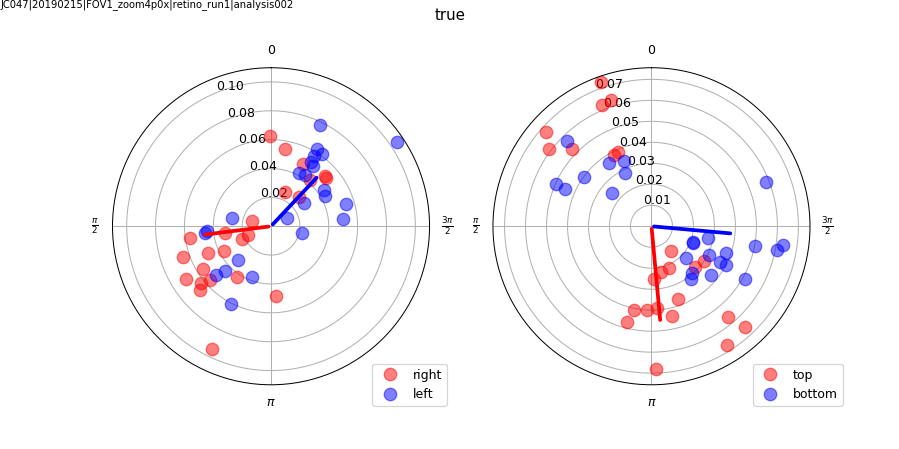

In [61]:

fig = pl.figure(figsize=(10,5))

color1 = 'r'
color2 = 'b'

xL=['0',r'$\frac{\pi}{4}$',r'$\frac{\pi}{2}$',r'$\frac{3\pi}{4}$',\
    r'$\pi$',r'$\frac{5\pi}{4}$',r'$\frac{3\pi}{2}$',r'$\frac{7\pi}{4}$']
xL = xL[::2]

for ci, (c1, c2) in enumerate([['right', 'left'], ['top', 'bottom']]): #['right']:
    ax = fig.add_subplot(1, 2, ci+1, projection='polar')
    cond1 = np.array([fit_results[rid]['roi_fit'][c1]['params']['init_phase'] for rid in best_fits])
    cond2 = np.array([fit_results[rid]['roi_fit'][c2]['params']['init_phase'] for rid in best_fits])
    if not use_corrected:
        cond1 = vf.correct_phase_wrap(cond1)
        cond2 = vf.correct_phase_wrap(cond2)
        
        
    mag1 = [magratio[trials_by_cond[c1]].iloc[rid].mean() for rid in best_fits]
    mag2 = [magratio[trials_by_cond[c2]].iloc[rid].mean() for rid in best_fits]

    ax.plot(cond1, mag1, 'o',alpha=0.5, label=c1, color=color1, markersize=10) #[cond])
    ax.plot(cond2, mag2, 'o', alpha=0.5, label=c2, color=color2, markersize=10) 
    ax.annotate("", xy=( sp.stats.circmean(cond1, high=highval, low=lowval), np.mean(mag1)), xytext=(0, 0), 
                arrowprops=dict(arrowstyle="-", edgecolor=color1, linewidth=3))
    ax.annotate("", xy=( sp.stats.circmean(cond2, high=highval, low=lowval), np.mean(mag2)), xytext=(0, 0), 
                arrowprops=dict(arrowstyle="-", edgecolor=color2, linewidth=3))

    ax.set_theta_offset(np.pi/2) 
    pl.legend(loc='center left', bbox_to_anchor=(0.8, 0))
    
    xT = pl.xticks()[0][0::2]
    pl.xticks(xT, xL)

fig.suptitle('true')
 
label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'polar_compare_directions_true_%.2f.png' % threshold))

#### Visualize difference in phase between fit and true

<IPython.core.display.Javascript object>


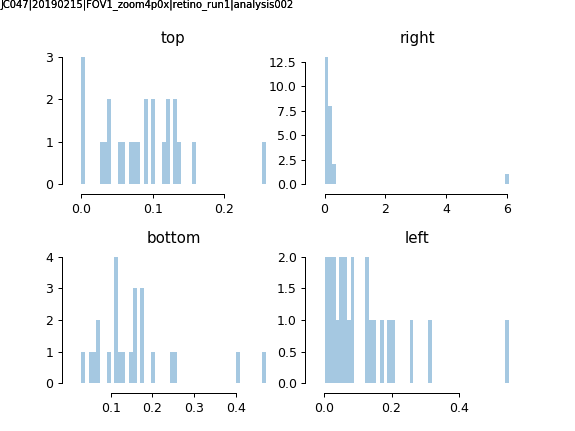

In [62]:
#### Look at histogram of diff between fit and true:

fig, axes = pl.subplots(2,2)
fit_diffs = {}
for ax, cond in zip(axes.flat, conditions):
    
    fit_vals = np.array([fit_results[rid]['roi_fit'][cond]['params']['fit_phase'] for rid in best_fits])
    true_vals = np.array([fit_results[rid]['roi_fit'][cond]['params']['init_phase'] for rid in best_fits])
    
    if not use_corrected:
        fit_vals = np.array([float(v) for v in vf.correct_phase_wrap(fit_vals)])
        true_vals = np.array([float(v) for v in vf.correct_phase_wrap(true_vals)])
        
    diffs = np.abs(fit_vals - true_vals)

    sns.distplot(diffs, ax=ax, kde=False, bins=50)
    ax.set_title(cond)
    
    fit_diffs[cond] = diffs
    
    #ax.set_xlim([-np.pi, np.pi])

sns.despine(trim=True, offset=8)
fig.subplots_adjust(hspace=0.5)

label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_fit_dir, 'hist_fit_vs_true_diff_by_cond_%.2f.png' % threshold))


<IPython.core.display.Javascript object>


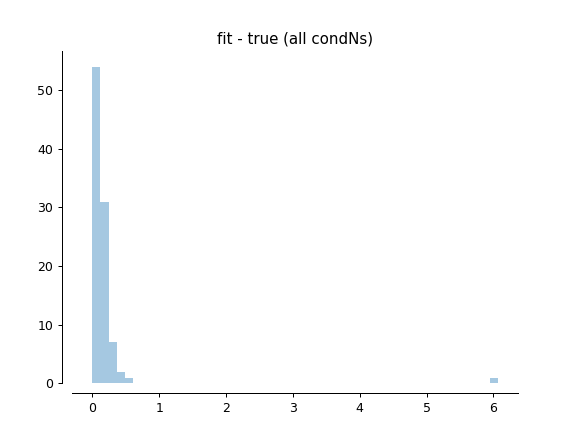

In [63]:
# Combine diffs for all conds:

all_diffs = [l for sublist in [vals for cond, vals in fit_diffs.items()] for l in sublist]

pl.figure()
sns.distplot(all_diffs, kde=False)
sns.despine(bottom=False, offset=8)
#pl.xlim([-np.pi, np.pi])
pl.title('fit - true (all condNs)')

label_figure(fig, data_identifier)
pl.savefig(os.path.join(roi_fit_dir, 'hist_fit_vs_true_diff_all_conds_%.2f.png' % threshold))


#### Visualize phase offset between opposing directions

<IPython.core.display.Javascript object>


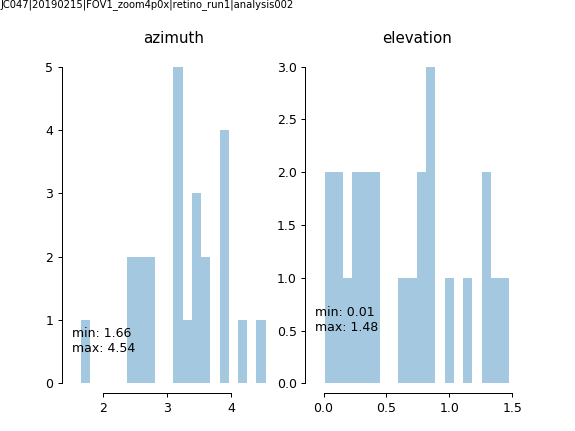

In [64]:
# TRUE data -- Look at diff between opposite dirs:

cond1 = np.array([fit_results[rid]['roi_fit']['right']['params']['init_phase'] for rid in best_fits])
cond2 = np.array([fit_results[rid]['roi_fit']['left']['params']['init_phase'] for rid in best_fits])

if not use_corrected:
    cond1 = vf.correct_phase_wrap(cond1)
    cond2 = vf.correct_phase_wrap(cond2)
    
diffs_az = np.abs(cond1-cond2)

cond1 = np.array([fit_results[rid]['roi_fit']['top']['params']['init_phase'] for rid in best_fits])
cond2 = np.array([fit_results[rid]['roi_fit']['bottom']['params']['init_phase'] for rid in best_fits])

if not use_corrected:
    cond1 = vf.correct_phase_wrap(cond1)
    cond2 = vf.correct_phase_wrap(cond2)
    
diffs_el = np.abs(cond1 - cond2)

fig, axes = pl.subplots(1,2) #pl.figure()
sns.distplot(diffs_az, kde=False,bins=20, ax=axes[0])
#axes[0].set_xlim([0, 2*np.pi])
axes[0].set_title('azimuth')
axes[0].text(axes[0].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_az.min(), diffs_az.max()))

sns.distplot(diffs_el, kde=False,bins=20, ax=axes[1])
#axes[1].set_xlim([0, 2*np.pi])
axes[1].set_title('elevation')
axes[1].text(axes[1].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_el.min(), diffs_el.max()))

sns.despine(offset=8, trim=True)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(roi_fit_dir, 'hist_diff_directions_true_%.2f.png' % threshold))

<IPython.core.display.Javascript object>


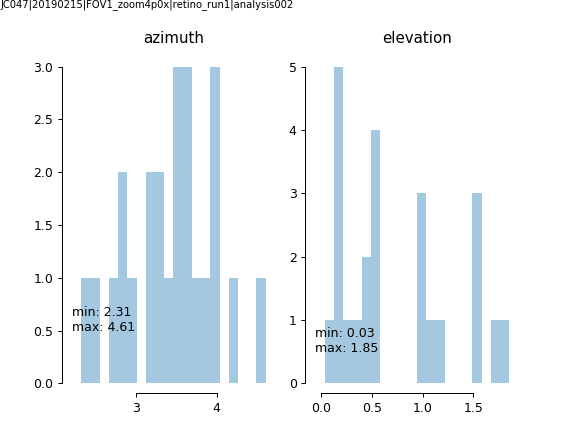

In [66]:
# FIT data:  Look at diff between opposite dirs:

cond1 = np.array([fit_results[rid]['roi_fit']['right']['params']['fit_phase'] for rid in best_fits])
cond2 = np.array([fit_results[rid]['roi_fit']['left']['params']['fit_phase'] for rid in best_fits])

if not use_corrected:
    cond1 = vf.correct_phase_wrap(cond1)
    cond2 = vf.correct_phase_wrap(cond2)
    
diffs_az = np.abs(cond1-cond2)

cond1 = np.array([fit_results[rid]['roi_fit']['top']['params']['fit_phase'] for rid in best_fits])
cond2 = np.array([fit_results[rid]['roi_fit']['bottom']['params']['fit_phase'] for rid in best_fits])

if not use_corrected:
    cond1 = vf.correct_phase_wrap(cond1)
    cond2 = vf.correct_phase_wrap(cond2)
    
diffs_el = np.abs(cond1 - cond2)

fig, axes = pl.subplots(1,2) #pl.figure()
sns.distplot(diffs_az, kde=False,bins=20, ax=axes[0])
#axes[0].set_xlim([0, 2*np.pi])
axes[0].set_title('azimuth')
axes[0].text(axes[0].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_az.min(), diffs_az.max()))

sns.distplot(diffs_el, kde=False,bins=20, ax=axes[1])
#axes[1].set_xlim([0, 2*np.pi])
axes[1].set_title('elevation')
axes[1].text(axes[1].get_xlim()[0], 0.5, 'min: %.2f\nmax: %.2f' % (diffs_el.min(), diffs_el.max()))

sns.despine(offset=8, trim=True)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(roi_fit_dir, 'hist_diff_directions_fit_%.2f.png' % threshold))

In [67]:
len(best_fits)

24

# Test delay with PIXEL maps

In [73]:
pixelmap_dir = os.path.join(roi_fit_dir, 'pixelmaps')
if not os.path.exists(pixelmap_dir):
    os.makedirs(pixelmap_dir)
print("Saving PIXEL output to: %s" % pixelmap_dir)


Saving PIXEL output to: /n/coxfs01/2p-data/JC047/20190215/FOV1_zoom4p0x/retino_run1/retino_analysis/analysis001_9b4dc6/fits/pixelmaps


(65536,)


<IPython.core.display.Javascript object>


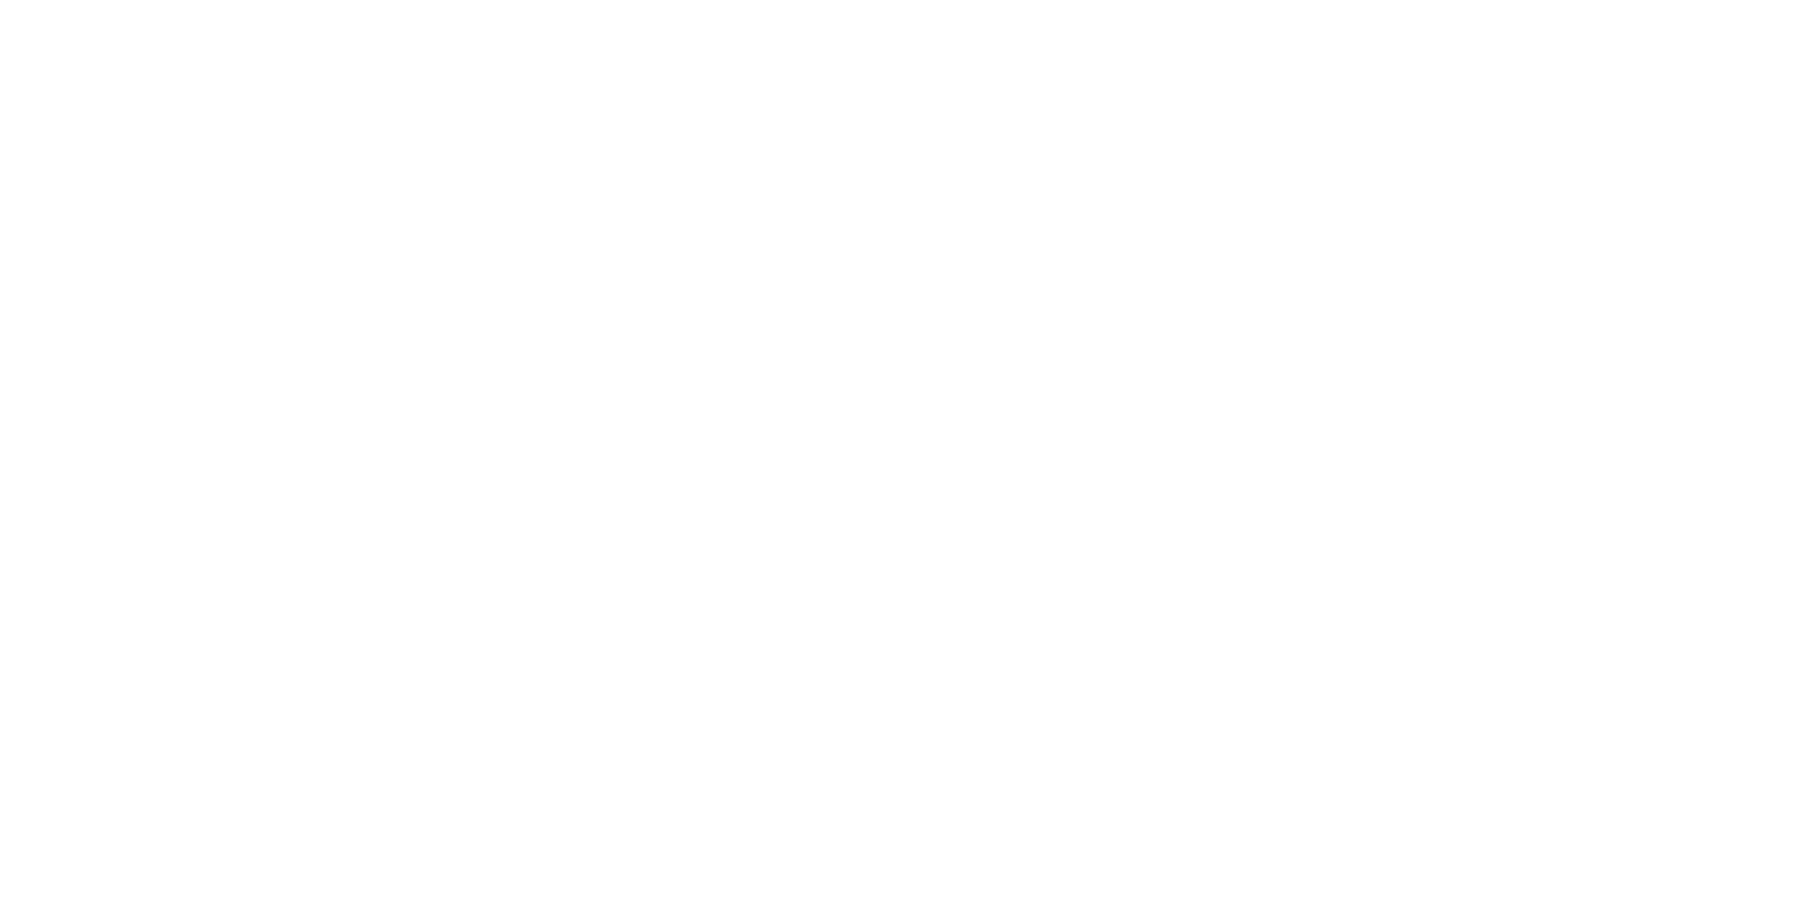

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:58: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


<IPython.core.display.Javascript object>


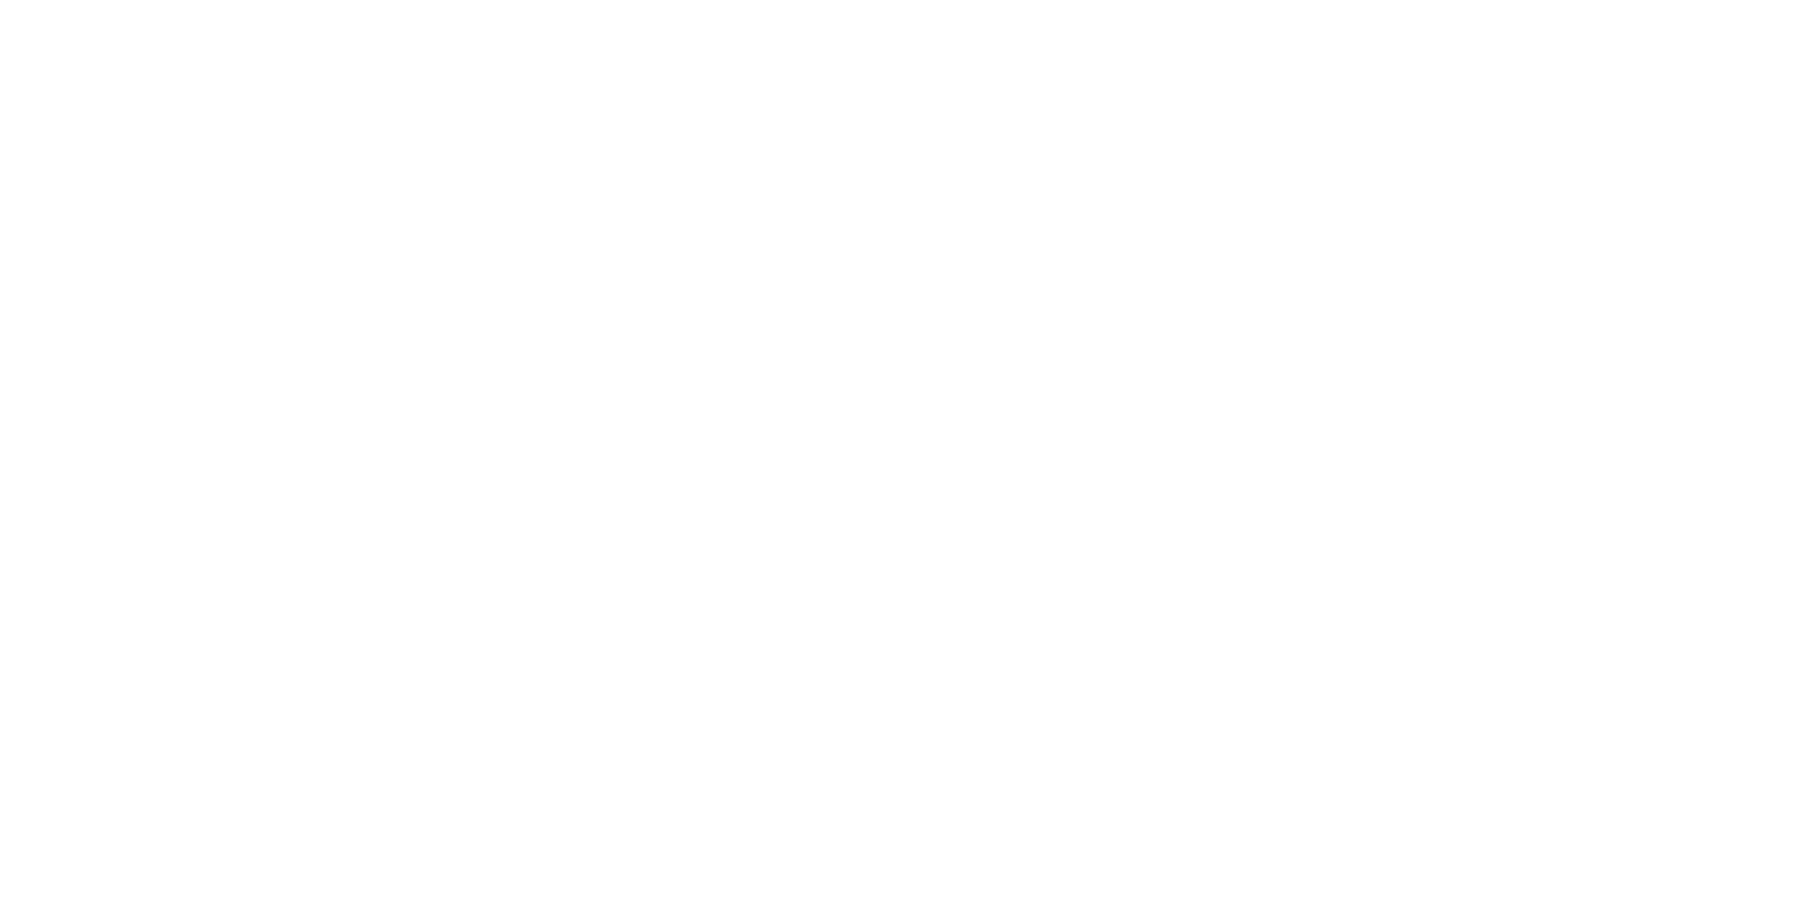

In [74]:

# Compare L/R and U/D to check for delay in GCaMP signal:
az = ['right', 'left']
el = ['top', 'bottom']

phase_right = corrected_phase[trials_by_cond['right']]
phase_left = corrected_phase[trials_by_cond['left']]
phase_top = corrected_phase[trials_by_cond['top']]
phase_bottom = corrected_phase[trials_by_cond['bottom']]

avg_right = sp.stats.circmean(phase_right, axis=1)
avg_left = sp.stats.circmean(phase_left, axis=1)
avg_top = sp.stats.circmean(phase_top, axis=1)
avg_bottom = sp.stats.circmean(phase_bottom, axis=1)

delay_az = (avg_right + avg_left ) / 2.
delay_el = (avg_top + avg_bottom ) / 2.

overall_mag_ratios = magratio.mean(axis=1)
print(overall_mag_ratios.shape)

cmap = 'nipy_spectral'
vmin = 0
vmax = 2*np.pi
d1 = int(np.sqrt(overall_mag_ratios.shape[0]))
d2 = int(np.sqrt(overall_mag_ratios.shape[0]))


#%%%
for direction in [az, el]:
    assert len(direction) == 2, "Not enough directions found: %s" % str(direction)

    nreps = len(phase_right.columns.tolist())
    fig, axes = pl.subplots(2, nreps+1,figsize=(5*(nreps+1), 10))

    for cond_ix, cond in enumerate(direction):
        if cond == 'right':
            nreps = len(phase_right.columns.tolist())
            trial_phase_vals = phase_right.copy()
            avg_phase_vals = avg_right.copy()
        elif cond == 'left':
            nreps = len(phase_left.columns.tolist())
            trial_phase_vals = phase_left.copy()
            avg_phase_vals = avg_left.copy()
        elif cond == 'top':
            nreps = len(phase_top.columns.tolist())
            trial_phase_vals = phase_top.copy()
            avg_phase_vals = avg_top.copy()
        else:
            nreps = len(phase_bottom.columns.tolist())
            trial_phase_vals = phase_bottom.copy()
            avg_phase_vals = avg_bottom.copy()


        for trialnum in np.arange(0, nreps):
            axes[cond_ix, trialnum].imshow(trial_phase_vals[trials_by_cond[cond][trialnum]].reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, trialnum].set_title('%s, rep %i' % (cond, trialnum))
            axes[cond_ix, trialnum].imshow(trial_phase_vals[trials_by_cond[cond][trialnum]].reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, trialnum].set_title('%s, rep %i' % (cond, trialnum))
            axes[cond_ix, trialnum].axis('off')

            axes[cond_ix, nreps].imshow(avg_phase_vals.reshape((d1, d2)), cmap=cmap, vmin=vmin, vmax=vmax)
            axes[cond_ix, nreps].set_title('%s, average' % cond)
            axes[cond_ix, nreps].axis('off')
    
    label_figure(fig, data_identifier)
    pl.savefig(os.path.join(pixelmap_dir, 'average_maps_%s.png' % direction))
    pl.close()
    

### Calculate delay map:

<IPython.core.display.Javascript object>


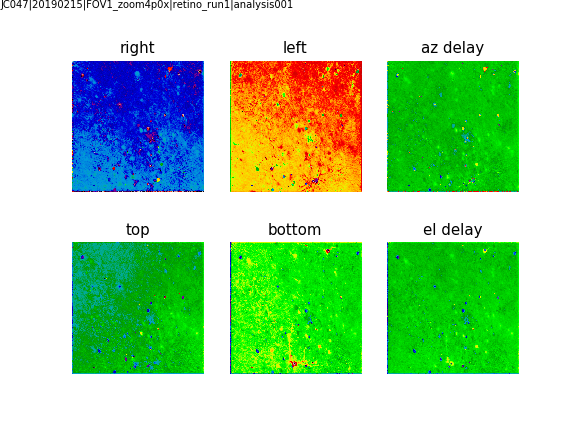

In [75]:

phasemap_right = np.reshape(avg_right, (d1, d2))
phasemap_left = np.reshape(avg_left, (d1, d2))
az_delay = (phasemap_left + phasemap_right) / 2.

phasemap_top = np.reshape(avg_top, (d1, d2))
phasemap_bottom = np.reshape(avg_bottom, (d1, d2))
el_delay = (phasemap_bottom + phasemap_top) / 2.

fig, ax = pl.subplots(2,3)

# Plot original RIGHT:
im0 = ax[0, 0].imshow(phasemap_right, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 0].set_title('right'); ax[0, 0].axis('off');

# Plot original LEFT:
im1 = ax[0, 1].imshow(phasemap_left, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 1].set_title('left'); ax[0, 1].axis('off')

# Plot AZ delay map:
ax[0, 2].imshow(az_delay, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 2].set_title('az delay'); ax[0, 2].axis('off')



# Plot original TOP:
im0 = ax[1, 0].imshow(phasemap_top, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 0].set_title('top'); ax[1, 0].axis('off');

# Plot original BOTTOM:
im1 = ax[1, 1].imshow(phasemap_bottom, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 1].set_title('bottom'); ax[1, 1].axis('off')

# Plot EL delay map:
ax[1, 2].imshow(el_delay, cmap=cmap, vmin=vmin, vmax=vmax)
ax[1, 2].set_title('el delay'); ax[1, 2].axis('off')

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pixelmap_dir, 'delay_maps.png'))

<IPython.core.display.Javascript object>


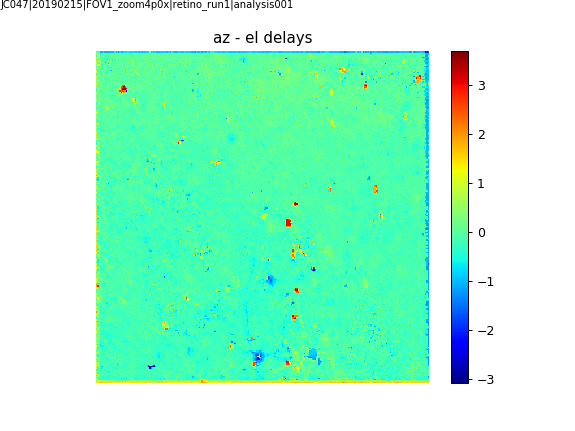

In [93]:
fig = pl.figure()
pl.imshow(az_delay - el_delay, cmap='jet')
pl.colorbar()
pl.axis('off')
pl.title('az - el delays')
label_figure(fig, data_identifier)
pl.savefig(os.path.join(pixelmap_dir, 'delay_difference.png'))

<IPython.core.display.Javascript object>


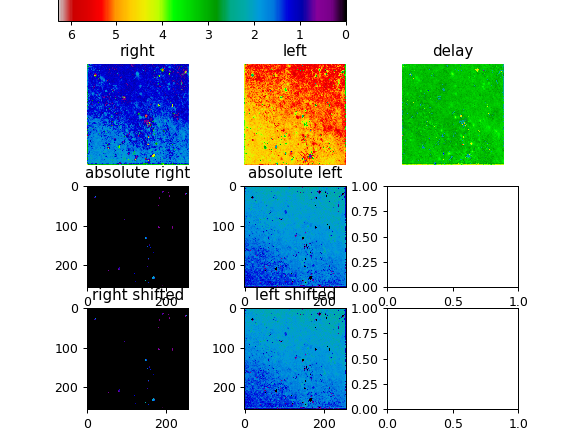

In [82]:

phasemap_right = np.reshape(avg_right, (d1, d2))
phasemap_left = np.reshape(avg_left, (d1, d2))

az_delay = (phasemap_left + phasemap_right) / 2.

fig, ax = pl.subplots(3,3)

# Plot original RIGHT:
im0 = ax[0, 0].imshow(phasemap_right, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 0].set_title('right'); ax[0, 0].axis('off');

# Plot original LEFT:
im1 = ax[0, 1].imshow(phasemap_left, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 1].set_title('left'); ax[0, 1].axis('off')

# Plot AZ delay map:
ax[0, 2].imshow(az_delay, cmap=cmap, vmin=vmin, vmax=vmax)
ax[0, 2].set_title('delay'); ax[0, 2].axis('off')

# Plot absolute "right":
absolute_right = (phasemap_right - phasemap_left) / 2.
ax[1, 0].set_title('absolute right')
ax[1, 0].imshow(absolute_right, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot absolute "left":
absolute_left = (phasemap_left - phasemap_right) / 2.
ax[1, 1].set_title('absolute left')
ax[1, 1].imshow(absolute_left, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot right map, shifted by delay:
right_subtract_delay = phasemap_right-az_delay #(az_delay - phasemap_right)
ax[2, 0].set_title('right shifted')
ax[2, 0].imshow(right_subtract_delay, cmap=cmap, vmin=vmin, vmax=vmax)

# Plot left map, shifted by delay:
left_subtract_delay = (phasemap_left - az_delay)
ax[2, 1].set_title('left shifted')
ax[2, 1].imshow(left_subtract_delay, cmap=cmap, vmin=vmin, vmax=vmax)

pl.subplots_adjust(bottom=0.05, top=0.85)
# Now adding the colorbar
cbaxes = fig.add_axes([0.1, 0.95, 0.5, 0.05]) 
cb = pl.colorbar(im1, cax = cbaxes, orientation='horizontal')  
cb.ax.invert_xaxis() 
